# OCRDemo2

This is a re-working of my previous [OCRDemo](https://colab.research.google.com/drive/1B2EJ1yOuXUc0sAUV023gRoG0NOGrRnEl?usp=sharing) notebook, which successfully parsed files but did not handle adverse conditions such as filename collisions, incorrectly oriented pages, and languages other than English. Here, I attempt to address these issues.

## Utility Functions

In [ ]:
def get_df(title, gc, worksheet=0, has_headers=True):
    """Returns a pandas.DataFrame representation of the
    (WORKSHEET)th worksheet of the Google Sheets (GSHEET)
    file that has title TITLE.
    TITLE - the title of the desired spreadsheet
    GC    - the GSpread credentials needed to retrieve the spreadsheet
    WORKSHEET - the index of the desired worksheet within
        the spreadsheet
    HAS_HEADERS - set to False if the spreadsheet does not
        have a header row at the top.
    It is not necessary to specify the path or the GSHEET
    file extension. Note that this creates undefined
    behavior when your google drive has multiple spreadsheets
    with the same name (i.e., you do not know which one
    will be opened).
    """
    # For details on how to handle GSHEET files, see
    # https://gspread.readthedocs.io/en/latest/api.html
    contents = gc.open(title).get_worksheet(worksheet).get_all_values()
    if has_headers:
        return pd.DataFrame.from_records(
            data=contents[1:],
            columns=contents[0]
        )
    return pd.DataFrame.from_records(contents)

## Initial Setup
Here, I install or import the required packages, set global variables, and so forth.

I am using PyDrive so that I can access files by ID. This prevents me from having to work directly with the [googleapiclient.discovery module](https://googleapis.github.io/google-api-python-client/docs/epy/googleapiclient.discovery-module.html), which is slightly less user-friendly.

In [ ]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

Great! Now I can easily download files by ID from Google Drive.
Here, I download Tesseract with **all** languages supported.

In [ ]:
# The capture command is used here to minimize visual clutter.
%%capture
!sudo apt-get install tesseract-ocr-all
!pip3 install pytesseract
!pip install langdetect
!pip install pdf2image
!apt-get install poppler-utils

These are the packages I will use...

In [ ]:
import pytesseract
from pytesseract import TesseractError
from PIL import Image
import os
import gspread
from pdf2image import convert_from_path
import pandas as pd
from io import StringIO
import re
import langdetect
from langdetect.lang_detect_exception import LangDetectException
import csv
import time
import pickle
import warnings
# The following packages are for testing and will not be dependencies in the final program.
import requests

* It is necessary to mount the drive in order to permanently save OCR output.
* It is convenient to install the `gsheets` package for easy access to the catalog file.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


The `OCR_OUT_PATH` is the directory where all OCR output generated by this notebook will be saved. Within this folder, the file stucture will parallel the file structure of the source folders, as specified in the catalog file.

In [ ]:
OCR_OUT_PATH = '/content/drive/MyDrive/AWCA/Colab_notebooks/OCR/pDonovan/OCR_OUT_TEST'
CATALOG_NAME = 'catalog.20200407.aa'

In [ ]:
CATALOG = get_df(
    CATALOG_NAME,
    gspread.authorize(GoogleCredentials.get_application_default())
)
CATALOG.head()

,ID,md5,Size,mime-type,Created Date,Modified Date,Folder,Name
0,0B9Ibqa26YXiReTZaVm9OWmNxSlk,8,1,application/vnd.google-apps.folder,None,None,ane.pdf.share,
1,1SM5HksnY6AMPpTdSU5ww9-HPiQ99XfgSE7WrLhGlBDA,None,None,application/vnd.google-apps.spreadsheet,2016-12-16T21:40:27.784Z,2018-03-06T17:00:11.204Z,ane.pdf.share,Copy of PDFtp Catalog
2,0B9Ibqa26YXiRV0N4VjF4X1dFWGs,26,2,application/vnd.google-apps.folder,2015-10-28T02:49:34.608Z,2018-04-25T18:57:32.604Z,ane.pdf.share/By Author (or editor),
3,11QJyX5cD2fOKFOv3IZreja87dZGKSh-hIdqCIkuWd6k,None,None,application/vnd.google-apps.spreadsheet,2011-06-14T22:12:39.027Z,2018-06-11T08:30:28.072Z,ane.pdf.share/By Author (or editor),PDFtp Files: Dirty
4,1FmwBRqFmXyG--6akcrQGBE6yVmKOl8L3PXTtzT8_jew,None,None,application/vnd.google-apps.spreadsheet,2011-06-15T00:58:25.597Z,2019-07-05T14:36:16.263Z,ane.pdf.share/By Author (or editor),PDFtp WishList & Catalog


## Classes

In [ ]:
class WeightTracker:
  """Tracks the weights of items and supports iteration over them in
  order.
  All objects in the universe are in any WeightTracker instance,
  regardless of whether they have been explicitly added; by default, their
  weights are 0.
  """
  def __init__(self, items, presorted=True, r=0.5):
    """Initializes a WeightTracker that tracks the weights of ITEMS.
    ITEMS - the items whose weights are to be tracked. These items must be
            hashable.
    PRESORTED - whether ITEMS is presorted in order of DECREASING expected
            importance
    R     - the proportion by which all weights should in response to
            each weight update. Set to a large value (close to 1) to make the
            WeightTracker weight recent observations and old observations
            equally heavily. Set to a small value (close to 0) to make old
            observations relatively unimportant.
    """
    self.items = items
    self.r = r
    self.weights = {
        item: (1 / (i + 1) if presorted else 0)
        for i, item in enumerate(items)
    }
  def add_weight(self, item):
    """Increases the weight given to ITEM.
    """
    self.weights = {item: self.weights[item] * self.r for item in self.items}
    self.weights[item] = self.weights.get(item, 0) + 1
    self.items.sort(key=lambda item: self.weights[item], reverse=True)

class Text:
  """Describes a single text that includes a coherent set of characteristics,
  such as language used.
  """
  global_possible_languages = [
      'eng', 'tur', 'ara', 'deu', 'fra', 'rus', 'spa', 'nld',
      'jpn', 'chi_sim', 'chi_tra', 'heb', 'ita', 'dan', 'swe',
      'ell', 'lat', 'fin'
  ]
  languages_by_script = {
      'Latin': {'eng', 'tur', 'deu', 'fra', 'spa', 'nld', 'ita', 'dan', 'swe', 'fin'},
      'Arabic': {'ara'},
      'Cyrillic': {'rus', 'ell'}, # Tesseract seems to recognize Greek as
                                  # Cyrillic, so 'ell' is included here.
                                  # This is an ugly and undesirable workaround.
      'Japanese': {'jpn'},
      'Japanese_vert': {'jpn'},
      'Han': {'chi_sim', 'chi_tra'},
      'Hebrew': {'heb'},
  }
  iso2tess = {
      'en': 'eng',
      'tr': 'tur',
      'ar': 'ara',
      'de': 'deu',
      'fr': 'fra',
      'ru': 'rus',
      'es': 'spa',
      'nl': 'nld',
      'ja': 'jpn',
      'zh': 'chi_sim',
      'zh': 'chi_tra',
      'he': 'heb',
      'it': 'ita',
      'da': 'dan',
      'sv': 'swe',
      'el': 'ell',
      'la': 'lat',
      'fi': 'fin'
  }
  def __init__(self, src, out,
               coarse_thresh=75, min_relative_conf=0,
               languages=None, second_languages=None,
               verbose=False):
    """Initializes a Text object from the file specified at SRC.
    PATH must lead to a directory that does not yet exist.
    SRC - the path to the file to be analyzed. When accessing files in Google
          Drive, it is recommended to access them by ID to circumvent name
          conflicts, save a temporary file in a different location, and pass the
          location of the temporary file as SRC.
    OUT - the path the the working directory of this Text object (where output
          is to be saved)
    COARSE_THRESH - the minimum mean confidence level by word required to assume
          that the OCR output is at least using the correct script and
          orientation
    MIN_RELATIVE_CONF - the minimum confidence level for a particular word
          relative to the mean confidence level of the entire page
    LANGUAGES - a WeightTracker instance with the expected languages weighted
          in accordance to their expected probabilities
    SECOND_LANGUAGES - a WeightTracker instance with the languages expected to
          appear in isolated foreign words (e.g., proper nouns)
    VERBOSE - whether detailed information should be printed by this Text
          instance
    """
    os.mkdir(out)
    self.src = src
    self.out = out
    self.coarse_thresh = coarse_thresh
    self.min_relative_conf = min_relative_conf
    self.languages = (
        WeightTracker(Text.global_possible_languages, presorted=True)
        if languages is None else languages
    )
    self.second_languages = (
        WeightTracker(Text.global_possible_languages)
        if second_languages is None else second_languages
    )
    self.verbose = verbose
    self.images_dir = os.path.join(self.out, 'images')
    self.page_paths = list()
    self.page_texts = list()
    self.page_metadata = list()
  def save_ocr(self):
    """Saves the OCR output to a CSV in the top level of the working directory
    of this Text object."""
    self._save_images()
    page_paths = os.listdir(self.images_dir)
    page_paths.sort()
    t0 = time.time()
    for i, path in enumerate(page_paths):
      if self.verbose:
        print('{} out of {} pages analyzed in {:.2f} seconds...'.format(
            i, len(page_paths), time.time() - t0))
      self._analyze_page(path)
    pd.DataFrame(data={
        'page_path': self.page_paths,
        'page_text': self.page_texts
    }).to_csv(os.path.join(self.out, 'page.csv'))
    self.save()
  def _save_images(self):
    """Saves images of the pages of the text in the working directory."""
    os.mkdir(self.images_dir)
    convert_from_path(self.src, output_folder=self.images_dir)
  def clean(self):
    """Deletes the files needed for intermediate steps in the analysis of the
    text.
    """
    os.rmdir(self.images_dir)
  def _analyze_page(self, path):
    """Analyzes the page whose image is located at PATH and records the data
    extracted from it. Does nothing if the page cannot be analyzed successfully.
    """
    image = Image.open(os.path.join(self.images_dir, path))
    # The following line relies on the assumption that the primary language of
    # our texts does not change very often and that most pages are oriented
    # correctly. If every page were in a different language, the following line
    # of code would give us a performance hit with very little benefit -- we
    # might as well go straight to OSD (orientation and script detection).
    try:
      language_used = self.languages.items[0]
      metadata = data(image, language_used)
      if mean_conf(metadata) < self.coarse_thresh:
        if self.verbose: print('First guess at orientation + language failed.')
        image, language_used, metadata = self._osd_assisted_analysis(image)
        if metadata is None: return
      language = detected_language(data_to_string(metadata.text))
      if language != language_used:
        if self.verbose:
          print('Retrying with detected language. Language={}'.format(language))
        metadata = data(image, language)
    except TesseractError as e:
      warnings.warn('Tesseract failed: ' + str(e))
      return
    if mean_conf(metadata) < self.coarse_thresh:
      warnings.warn('Failed to analyze image.')
    else:
      self.languages.add_weight(language)
      # WORD CORRECTION FEATURE DISABLED. TODO: fix the feature.
      # self._correct(image, metadata, mean_conf(metadata)+self.min_relative_conf)
    self.page_paths.append(path)
    self.page_metadata.append(metadata)
    self.page_texts.append(data_to_string(
        metadata.corrected if 'corrected' in metadata.columns else metadata.text
    ))
  def _osd_assisted_analysis(self, image):
    """Returns the image, language, and metadata produced from
    analyzing IMAGE with orientation and script detection.
    Returns (None, None, None) if OSD fails to detect a supported script.
    """
    osd_result = osd(image)
    image = image.rotate(osd_result['Orientation in degrees'], expand=True)
    if osd_result['Script'] not in Text.languages_by_script:
      warnings.warn('OSD failed.')
      return (None, None, None)
    poss_languages = Text.languages_by_script[osd_result['Script']]
    for language in self.languages.items:
      if language in poss_languages:
        return image, language, data(image, language)
  def _correct(self, image, metadata, min_conf):
    """Adds a column to the metadata table METADATA that is the corrected form
    of the words given in its "text" column.
    METADATA - the metadata table that is to be corrected
    MIN_CONF - the minimum confidence level required for a word to be assumed
              correct and excluded from further examination
    LANGUAGES - a WeightTracker instance containing the possible languages,
              encoded as Tesseract LangCodes
    """
    def corrector(row):
      """Uses data in ROW corresponding to a word shown in IMAGE to determine
      the text that most likely represents the word. Updates weights in
      SECOND_LANGUAGES depending on which languages successfully give
      high-certainty matches.
      """
      if 0 <= row.conf < min_conf:
        word_image = image.crop(
            (row.left, row.top, row.left+row.width, row.top+row.height))
        for language in self.second_languages.items:
          metadata = data(word_image, language,
              config='--psm 8') # This tells Tesseract to expect a single word.
          print('DEBUG: For language={}, confidence={} and guess={}'.format(
              language, mean_conf(metadata), data_to_string(metadata.text).strip()
          ))
          if mean_conf(metadata) >= min_conf:
            self.second_languages.add_weight(language)
            correct_word = data_to_string(metadata.text).strip()
            if self.verbose:
              print('Correcting "{}" to "{}" (lang={})'.format(
                  row.text, correct_word, language))
            return correct_word
      else:
        return row.text
    metadata['corrected'] = metadata.apply(corrector, axis=1)
  def save(self):
    with open(os.path.join(self.out, 'analysis.pickle'), 'wb') as dbfile:
      pickle.dump(self, dbfile)

def detected_language(text, default='eng'):
  """Returns the detected language of TEXT, using the LangCode recognized by
  Tesseract (as described here:
  https://tesseract-ocr.github.io/tessdoc/Data-Files-in-different-versions.html)
  TEXT - the text to analyze
  DEFAULT - the language to return if no likely language can be found
  """
  assert isinstance(text, str)
  try:
    # Output of DETECT_LANGS is in decreasing order by estimated probability
    for lang in langdetect.detect_langs(text):
      if lang.lang in Text.iso2tess:
        return Text.iso2tess[lang.lang]
  except LangDetectException:
    pass
  return default
  
def mean_conf(metadata):
  """Returns the mean confidence by word of the OCR output given by METADATA."""
  return metadata.conf[metadata.conf >= 0].mean()

def osd(image):
  """Returns a dictionary with orientation and script data for IMAGE."""
  s = pytesseract.image_to_osd(image)
  ret = dict()
  for line in s.split('\n'):
    if line:
      key, value = line.split(':')
      key, value = key.strip(), value.strip()
      ret[key] = appropriate_type(value)
  return ret
def appropriate_type(value):
  """Returns a representation of VALUE cast to the appropriate type."""
  try:
    return int(value)
  except ValueError:
    try:
      return float(value)
    except ValueError:
      return value
def data(image, language, config=''):
  """Returns a DataFrame with the OCR output corresponding to IMAGE along with
  additional metadata.
  """
  s = pytesseract.image_to_data(image, lang=language, config=config)
  return pd.read_csv(StringIO(s), sep='\t', quoting=csv.QUOTE_NONE)
def data_to_string(words):
  """Extracts a string from the metadata table column WORDS that is identical
  to the one generated by pytesseract.image_to_string. Used to avoid
  redundant computations.
  """
  # TODO: I was suprised to find that it was necessary to cast the words (direct
  # Tesseract output) as strings. Perhaps look into this.
  text = ' '.join('\n' if pd.isna(word) else str(word) for word in words)
  single_newline = re.compile(r' \n ')
  multiple_newline = re.compile(r'( \n){2,} ')
  text = multiple_newline.sub('\n\n', text)
  text = single_newline.sub('\n', text)
  return text

## Brief Detour: Reverse Engineering `image_to_string`

This section is uninteresting and almost trivial. Feel free to skip.

In [ ]:
url = 'https://www.researchgate.net/profile/Diane-Schallert/publication/288057676/figure/fig1/AS:613969366622247@1523393112783/Figure-A2-Island-text-Neutral-version-English.png'
src = Image.open(requests.get(url, stream=True).raw)
osd(src)
output = data(src, 'eng')
mean_conf(output)

94.89272030651341

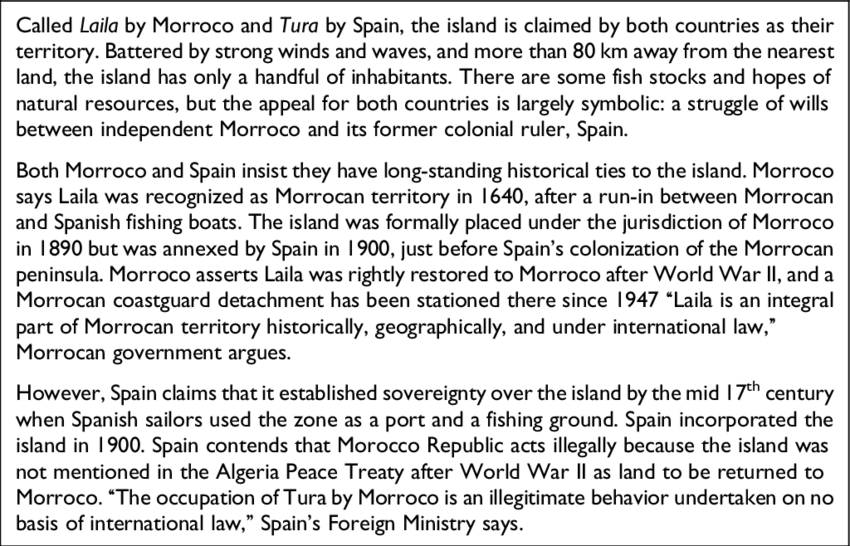

In [ ]:
src

In [ ]:
pytesseract.image_to_string(src, lang='eng')

' \n\n \n\nCalled Laila by Morroco and Tura by Spain, the island is claimed by both countries as their\nterritory. Battered by strong winds and waves, and more than 80 km away from the nearest\nland, the island has only a handful of inhabitants. There are some fish stocks and hopes of\nnatural resources, but the appeal for both countries is largely symbolic: a struggle of wills\nbetween independent Morroco and its former colonial ruler, Spain.\n\nBoth Morroco and Spain insist they have long-standing historical ties to the island. Morroco\nsays Laila was recognized as Morrocan territory in 1640, after a run-in between Morrocan\nand Spanish fishing boats. The island was formally placed under the jurisdiction of Morroco\nin 1890 but was annexed by Spain in | 900, just before Spain’s colonization of the Morrocan\npeninsula. Morroco asserts Laila was rightly restored to Morroco after World War Il, anda\nMorrocan coastguard detachment has been stationed there since 1947 “Laila is an integral

It is evident that `pytesseract.image_to_string` does the same thing as `pytesseract.image_to_data`. All it seems to do is join the `text` column of the `image_to_data` output with spaces, except when the text is `NaN`, in which case it is interpreted as a newline character. Additionally, `image_to_string` does not pad newline characters with spaces, and for some reason it does not provide more than two consecutive newline characters.

In [ ]:
print(data_to_string(output.text))




thus founding the line of Hittite kings. The inhabitants thus referred to the Hittite language as NeSili, "the
language of NeSa".

Archaeology [edit]

In 1925, Bedi‘ich Hrozny excavated Killtepe and found over
1000 cuneiform tablets, some of which ended up in Prague and
in Istanbul.{61!7]

Modern archaeological work began in 1948, when Ktltepe was

excavated by a team from the Turkish Historical Society and the
General Directorate of Antiquities and Museums. The team was.
led by Tahsin Ozgiig until his death, in 2005.

 

e Level IV-III. Little excavation has been done for these levels,

=]
which represent the karum’s first habitation (Mellaart 1957). Avessel shaped rhyton from
Uiter
No writing is attested, and archaeologists assume that both a


In [ ]:
print(pytesseract.image_to_string(src, lang='eng'))

thus founding the line of Hittite kings. The inhabitants thus referred to the Hittite language as NeSili, "the
language of NeSa".

Archaeology [edit]

In 1925, Bedi‘ich Hrozny excavated Killtepe and found over
1000 cuneiform tablets, some of which ended up in Prague and
in Istanbul.{61!7]

Modern archaeological work began in 1948, when Ktltepe was

excavated by a team from the Turkish Historical Society and the
General Directorate of Antiquities and Museums. The team was.
led by Tahsin Ozgiig until his death, in 2005.

 

e Level IV-III. Little excavation has been done for these levels,

=]
which represent the karum’s first habitation (Mellaart 1957). Avessel shaped rhyton from
Uiter
No writing is attested, and archaeologists assume that both a



## Testing `correct`

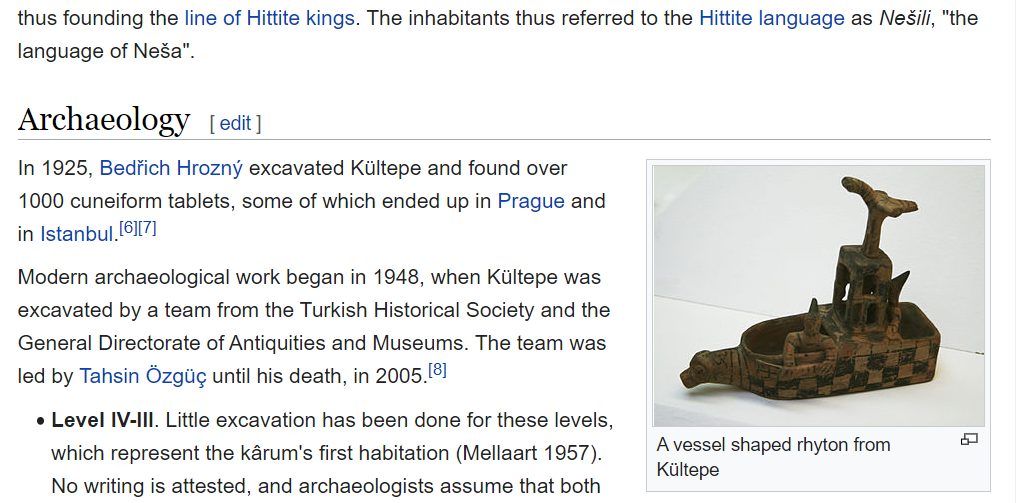

In [ ]:
path = '/content/drive/MyDrive/AWCA/Colab_notebooks/OCR/pDonovan/eng_with_foreign_words.png'
src = Image.open(path)
src

In [ ]:
output = data(src, 'eng')
mean_conf(output)

87.61344537815125

In [ ]:
print(data_to_string(output.text))




thus founding the line of Hittite kings. The inhabitants thus referred to the Hittite language as NeSili, "the
language of NeSa".

Archaeology [edit]

In 1925, Bedi‘ich Hrozny excavated Killtepe and found over
1000 cuneiform tablets, some of which ended up in Prague and
in Istanbul.{61!7]

Modern archaeological work began in 1948, when Ktltepe was

excavated by a team from the Turkish Historical Society and the
General Directorate of Antiquities and Museums. The team was.
led by Tahsin Ozgiig until his death, in 2005.

 

e Level IV-III. Little excavation has been done for these levels,

=]
which represent the karum’s first habitation (Mellaart 1957). Avessel shaped rhyton from
Uiter
No writing is attested, and archaeologists assume that both a


In [ ]:
correct(src, output, mean_conf(output))
print(data_to_string(output.corrected))

NameError: ignored

In [ ]:
'+'.join(Text.global_possible_languages)

In [ ]:
[a for a in output.corrected if a not in list(output.text)]

In [ ]:
[a for a in output.conf if 0 <= a < 85]

## Testing the `Text` class

In the following cell, I find the words that couldn't be identified with high confidence, and I try telling Tesseract to look at those words again, expecting them to be words in some other language. A few (very) small scale tests showed me that this works in cases where the words are real words or common names in some modern language, but in this case, it fails.

In [ ]:
src_path = '/content/drive/MyDrive/AWCA/PDFtp/ane.pdf.share/By Author (or editor)/S/Steinkeller, Piotr - The Umma Field Ušgida and the Question of GARšana’s Location. 2011.pdf'
out_path = os.path.join(OCR_OUT_PATH, 'test11')
test_text = Text(src_path, out_path, min_relative_conf=-5, verbose=True)
test_text.save_ocr()

0 out of 2 pages analyzed in 0.00 seconds...
DEBUG: For language=eng, confidence=53.0 and guess=LOCATION
DEBUG: For language=tur, confidence=41.0 and guess=Tİ OCATTON
DEBUG: For language=ara, confidence=59.0 and guess=اح صتمع0 1
DEBUG: For language=deu, confidence=25.0 and guess=I OCATION-
DEBUG: For language=fra, confidence=71.0 and guess=LOCATION
DEBUG: For language=rus, confidence=29.0 and guess=ГОСАТОМ.
DEBUG: For language=spa, confidence=89.0 and guess=LOCATION
Correcting "LOCATION”" to "LOCATION" (lang=spa)
DEBUG: For language=spa, confidence=51.0 and guess=a-Sags
DEBUG: For language=eng, confidence=37.0 and guess=a-Sagy
DEBUG: For language=tur, confidence=14.0 and guess=a-Sa£ı
DEBUG: For language=ara, confidence=92.5 and guess=2-5 4
Correcting "a-Sag4" to "2-5 4" (lang=ara)
DEBUG: For language=ara, confidence=6.0 and guess=15-510-03,
DEBUG: For language=spa, confidence=91.0 and guess=US-gid-da,
Correcting "US-gid-da," to "US-gid-da," (lang=spa)
DEBUG: For language=spa, confidenc

What have I learned? I have learned that technique is broken. Why is it broken? Because the foreign words that are causing problems aren't words in any a modern language. And because no language is written in subscripts and superscripts -- at least, not according to Tesseract. The subscripts simply aren't being handled.

Obviously, [other people have had this problem](https://stackoverflow.com/questions/63562290/can-tesseract-ocr-recognize-subscripts-and-superscripts). I am tempted to just write our own preprocessing software that just erases subscripts and superscripts: Detect the mean character size on the whole page. Find outliers (characters that are smaller than all the others). Look at the position of the outliers relative to the surrounding words to make sure they aren't regular punctuation or something like that. If not, erase them. How hard could it be? And the reason why I advocate for this is that as things stand right now, there is no way I would trust the accent detection from the OCR output. For NLP purposes, I would use Gensim to deaccent everything anyway.

For the moment, I will disable that feature.

In [ ]:
doc_name = 'Soloveitchik - Kol Dodi Dofek (Hebrew).pdf'
src_path = os.path.join('/content/drive/MyDrive/AWCA/PDFtp/ane.pdf.share/By Author (or editor)/S', doc_name)
out_path = os.path.join(OCR_OUT_PATH, 'test20')
test_text = Text(src_path, out_path, min_relative_conf=-5, verbose=True)
test_text.save_ocr()

0 out of 2 pages analyzed in 0.00 seconds...
First guess at orientation + language failed.
1 out of 2 pages analyzed in 11.75 seconds...


In [ ]:
test_text.languages.weights

{'ara': 0.08333333333333333,
 'chi_sim': 0.025,
 'chi_tra': 0.022727272727272728,
 'dan': 0.017857142857142856,
 'deu': 0.0625,
 'ell': 0.015625,
 'eng': 0.25,
 'fin': 0.013888888888888888,
 'fra': 0.05,
 'heb': 1.5208333333333335,
 'ita': 0.019230769230769232,
 'jpn': 0.027777777777777776,
 'lat': 0.014705882352941176,
 'nld': 0.03125,
 'rus': 0.041666666666666664,
 'spa': 0.03571428571428571,
 'swe': 0.016666666666666666,
 'tur': 0.125}

In [ ]:
test_text.languages.items

['heb',
 'eng',
 'tur',
 'ara',
 'deu',
 'fra',
 'rus',
 'spa',
 'nld',
 'jpn',
 'chi_sim',
 'chi_tra',
 'ita',
 'dan',
 'swe',
 'ell',
 'lat',
 'fin']

Looks good. Let's try German.

In [ ]:
doc_name = 'Soden, Wolfram von - Verbalformen mit doppeltem t-Infix im Akkadischen. Or NS 19, 1950 385-396.pdf'
src_path = os.path.join('/content/drive/MyDrive/AWCA/PDFtp/ane.pdf.share/By Author (or editor)/S', doc_name)
out_path = os.path.join(OCR_OUT_PATH, 'test23')
test_text = Text(src_path, out_path, verbose=True)
test_text.save_ocr()

0 out of 2 pages analyzed in 0.00 seconds...
Retrying with detected language. Language=deu
1 out of 2 pages analyzed in 21.16 seconds...


In [ ]:
test_text.languages.weights

{'ara': 0.08333333333333333,
 'chi_sim': 0.025,
 'chi_tra': 0.022727272727272728,
 'dan': 0.017857142857142856,
 'deu': 1.5625,
 'ell': 0.015625,
 'eng': 0.25,
 'fin': 0.013888888888888888,
 'fra': 0.05,
 'heb': 0.020833333333333332,
 'ita': 0.019230769230769232,
 'jpn': 0.027777777777777776,
 'lat': 0.014705882352941176,
 'nld': 0.03125,
 'rus': 0.041666666666666664,
 'spa': 0.03571428571428571,
 'swe': 0.016666666666666666,
 'tur': 0.125}

In [ ]:
doc_name = 'Sigrist, Marcel - Old Babylonian Account Texts in the Horn Archaeology Museum. AUCT 4. 1990.pdf'
src_path = os.path.join('/content/drive/MyDrive/AWCA/PDFtp/ane.pdf.share/By Author (or editor)/S', doc_name)
out_path = os.path.join(OCR_OUT_PATH, 'test24')
test_text = Text(src_path, out_path, verbose=True)
test_text.save_ocr()

0 out of 2 pages analyzed in 0.00 seconds...
Retrying with detected language. Language=eng
1 out of 2 pages analyzed in 21.60 seconds...


In [ ]:
doc_name = 'Sass, Marzahn 2010 Aramaic and Figural Stamp Impressions on Bricks of the 6th Cent BC from Babylon, WVDOG 127.pdf'
src_path = os.path.join('/content/drive/MyDrive/AWCA/PDFtp/ane.pdf.share/By Author (or editor)/S', doc_name)
out_path = os.path.join(OCR_OUT_PATH, 'test25')
test_text = Text(src_path, out_path, verbose=True)
test_text.save_ocr()

0 out of 2 pages analyzed in 0.00 seconds...
1 out of 2 pages analyzed in 8.93 seconds...


In [ ]:
doc_name = 'Sørensen 1982 - Redundans og Abstraction I det Ægyptiske Daglige Tempelritual (Chaos 1) .PDF'
src_path = os.path.join('/content/drive/MyDrive/AWCA/Colab_notebooks/OCR/MixLangTest', doc_name)
out_path = os.path.join(OCR_OUT_PATH, 'test28')
test_text = Text(src_path, out_path, verbose=True)
test_text.save_ocr()

0 out of 3 pages analyzed in 0.00 seconds...
Retrying with detected language. Language=dan
1 out of 3 pages analyzed in 14.83 seconds...
2 out of 3 pages analyzed in 33.63 seconds...


## Running the Program on MixLangTest

I confess that I cheated a little by pre-checking the program on the Sørensen paper (I had trouble finding any other orientation test case.) However, it worked the first time. Otherwise, I did not tailor this program specifically to work on MixLangTest by looking closely at the exact contents of MixLangTest.

In [ ]:
mix_lang_test = '/content/drive/MyDrive/AWCA/Colab_notebooks/OCR/MixLangTest'
for i, doc_name in enumerate(os.listdir(mix_lang_test)):
  src_path = os.path.join('/content/drive/MyDrive/AWCA/Colab_notebooks/OCR/MixLangTest', doc_name)
  out_path = os.path.join(OCR_OUT_PATH, 'MixLangTest{}'.format(i))
  test_text = Text(src_path, out_path, verbose=True)
  test_text.save_ocr()

0 out of 3 pages analyzed in 0.00 seconds...
First guess at orientation + language failed.
DEBUG: {'Page number': 0, 'Orientation in degrees': 180, 'Rotate': 180, 'Orientation confidence': 0.39, 'Script': 'Cyrillic', 'Script confidence': 1.43}
Retrying with detected language. Language=eng


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:163: UserWarning: Failed to analyze image.


1 out of 3 pages analyzed in 7.92 seconds...
Retrying with detected language. Language=eng
2 out of 3 pages analyzed in 13.82 seconds...
0 out of 3 pages analyzed in 0.00 seconds...
First guess at orientation + language failed.
DEBUG: {'Page number': 0, 'Orientation in degrees': 270, 'Rotate': 90, 'Orientation confidence': 12.82, 'Script': 'Cyrillic', 'Script confidence': 0.5}


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:163: UserWarning: Failed to analyze image.


1 out of 3 pages analyzed in 17.34 seconds...
2 out of 3 pages analyzed in 18.42 seconds...
First guess at orientation + language failed.
DEBUG: {'Page number': 0, 'Orientation in degrees': 270, 'Rotate': 90, 'Orientation confidence': 0.59, 'Script': 'Cyrillic', 'Script confidence': 4.44}


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:163: UserWarning: Failed to analyze image.


0 out of 3 pages analyzed in 0.00 seconds...
Retrying with detected language. Language=deu
1 out of 3 pages analyzed in 4.16 seconds...


KeyboardInterrupt: ignored

Oops, I had a little bit of a false start there. I had forgotten to take out the code I was using for debugging: looking at only a few pages instead of the whole document, and printing "DEBUG" messages.

In [ ]:
mix_lang_test = '/content/drive/MyDrive/AWCA/Colab_notebooks/OCR/MixLangTest'
for i, doc_name in enumerate(os.listdir(mix_lang_test)):
  src_path = os.path.join('/content/drive/MyDrive/AWCA/Colab_notebooks/OCR/MixLangTest', doc_name)
  out_path = os.path.join(OCR_OUT_PATH, 'MixLangTest2_{}'.format(i))
  test_text = Text(src_path, out_path, verbose=True)
  test_text.save_ocr()

0 out of 41 pages analyzed in 0.00 seconds...
First guess at orientation + language failed.
Retrying with detected language. Language=eng


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:163: UserWarning: Failed to analyze image.


1 out of 41 pages analyzed in 7.89 seconds...
2 out of 41 pages analyzed in 10.48 seconds...
3 out of 41 pages analyzed in 19.08 seconds...
4 out of 41 pages analyzed in 31.92 seconds...
5 out of 41 pages analyzed in 45.38 seconds...
6 out of 41 pages analyzed in 54.78 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:181: UserWarning: OSD failed.


7 out of 41 pages analyzed in 72.81 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:163: UserWarning: Failed to analyze image.


8 out of 41 pages analyzed in 113.75 seconds...
9 out of 41 pages analyzed in 121.21 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:163: UserWarning: Failed to analyze image.


10 out of 41 pages analyzed in 142.03 seconds...
11 out of 41 pages analyzed in 151.23 seconds...
12 out of 41 pages analyzed in 174.62 seconds...
13 out of 41 pages analyzed in 198.00 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:181: UserWarning: OSD failed.


14 out of 41 pages analyzed in 207.45 seconds...
15 out of 41 pages analyzed in 210.53 seconds...
16 out of 41 pages analyzed in 220.61 seconds...
17 out of 41 pages analyzed in 241.20 seconds...
18 out of 41 pages analyzed in 257.60 seconds...
First guess at orientation + language failed.
19 out of 41 pages analyzed in 270.17 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:163: UserWarning: Failed to analyze image.


20 out of 41 pages analyzed in 279.86 seconds...
First guess at orientation + language failed.
21 out of 41 pages analyzed in 360.60 seconds...
22 out of 41 pages analyzed in 390.04 seconds...
23 out of 41 pages analyzed in 416.69 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:163: UserWarning: Failed to analyze image.


24 out of 41 pages analyzed in 457.99 seconds...
First guess at orientation + language failed.
Retrying with detected language. Language=eng


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:163: UserWarning: Failed to analyze image.


25 out of 41 pages analyzed in 470.42 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:163: UserWarning: Failed to analyze image.


26 out of 41 pages analyzed in 479.11 seconds...
Retrying with detected language. Language=deu
27 out of 41 pages analyzed in 515.93 seconds...
28 out of 41 pages analyzed in 533.42 seconds...
29 out of 41 pages analyzed in 551.59 seconds...
30 out of 41 pages analyzed in 570.93 seconds...
31 out of 41 pages analyzed in 590.74 seconds...
32 out of 41 pages analyzed in 607.40 seconds...
First guess at orientation + language failed.
33 out of 41 pages analyzed in 630.45 seconds...
First guess at orientation + language failed.
Retrying with detected language. Language=eng


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:163: UserWarning: Failed to analyze image.


34 out of 41 pages analyzed in 642.73 seconds...


NameError: ignored

Darn it. Fortunately, this is a small, simple bug to fix. The problem is in the imports, not the program I wrote.

What is more concerning is that for the first time, `langdetect` failed to find any features. However, this could just be because the page was not analyzable, e.g., it had just an image and not text, and OSD didn't fail for some reason, but `langdetect` did... But this is all speculation. I am not too worried yet.

In [ ]:
mix_lang_test = '/content/drive/MyDrive/AWCA/Colab_notebooks/OCR/MixLangTest'
for i, doc_name in enumerate(os.listdir(mix_lang_test)):
  src_path = os.path.join('/content/drive/MyDrive/AWCA/Colab_notebooks/OCR/MixLangTest', doc_name)
  out_path = os.path.join(OCR_OUT_PATH, 'MixLangTest3_{}'.format(i))
  test_text = Text(src_path, out_path, verbose=True)
  test_text.save_ocr()

0 out of 41 pages analyzed in 0.00 seconds...
First guess at orientation + language failed.
Retrying with detected language. Language=eng


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:163: UserWarning: Failed to analyze image.


1 out of 41 pages analyzed in 8.03 seconds...
First guess at orientation + language failed.
Retrying with detected language. Language=eng
2 out of 41 pages analyzed in 20.48 seconds...
3 out of 41 pages analyzed in 28.93 seconds...
4 out of 41 pages analyzed in 41.32 seconds...
5 out of 41 pages analyzed in 54.30 seconds...
6 out of 41 pages analyzed in 63.25 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:181: UserWarning: OSD failed.


7 out of 41 pages analyzed in 81.17 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:163: UserWarning: Failed to analyze image.


8 out of 41 pages analyzed in 121.50 seconds...
9 out of 41 pages analyzed in 128.96 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:163: UserWarning: Failed to analyze image.


10 out of 41 pages analyzed in 149.86 seconds...
11 out of 41 pages analyzed in 158.99 seconds...
12 out of 41 pages analyzed in 182.62 seconds...
13 out of 41 pages analyzed in 206.29 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:181: UserWarning: OSD failed.


14 out of 41 pages analyzed in 216.28 seconds...
15 out of 41 pages analyzed in 219.40 seconds...
16 out of 41 pages analyzed in 229.44 seconds...
17 out of 41 pages analyzed in 250.29 seconds...
18 out of 41 pages analyzed in 266.24 seconds...
First guess at orientation + language failed.
19 out of 41 pages analyzed in 278.93 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:163: UserWarning: Failed to analyze image.


20 out of 41 pages analyzed in 288.56 seconds...
First guess at orientation + language failed.
21 out of 41 pages analyzed in 370.10 seconds...
22 out of 41 pages analyzed in 399.83 seconds...
23 out of 41 pages analyzed in 426.45 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:163: UserWarning: Failed to analyze image.


24 out of 41 pages analyzed in 467.56 seconds...
First guess at orientation + language failed.
Retrying with detected language. Language=eng


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:163: UserWarning: Failed to analyze image.


25 out of 41 pages analyzed in 480.05 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:163: UserWarning: Failed to analyze image.


26 out of 41 pages analyzed in 488.74 seconds...
Retrying with detected language. Language=deu
27 out of 41 pages analyzed in 525.08 seconds...
28 out of 41 pages analyzed in 542.75 seconds...
29 out of 41 pages analyzed in 560.90 seconds...
30 out of 41 pages analyzed in 580.42 seconds...
31 out of 41 pages analyzed in 600.24 seconds...
32 out of 41 pages analyzed in 617.20 seconds...
First guess at orientation + language failed.
33 out of 41 pages analyzed in 640.17 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:163: UserWarning: Failed to analyze image.


34 out of 41 pages analyzed in 649.02 seconds...
Retrying with detected language. Language=eng
35 out of 41 pages analyzed in 652.29 seconds...
36 out of 41 pages analyzed in 673.76 seconds...
37 out of 41 pages analyzed in 692.22 seconds...
First guess at orientation + language failed.
38 out of 41 pages analyzed in 713.19 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:163: UserWarning: Failed to analyze image.


39 out of 41 pages analyzed in 723.18 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:163: UserWarning: Failed to analyze image.


40 out of 41 pages analyzed in 732.20 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:181: UserWarning: OSD failed.


0 out of 17 pages analyzed in 0.00 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:163: UserWarning: Failed to analyze image.


1 out of 17 pages analyzed in 20.97 seconds...
First guess at orientation + language failed.


TesseractError: ignored

I looked at the document that caused this issue. The image was a title page that was dark and not well-suited for OCR. All I am doing now is catching the exception and reporting it as a warning, just as I have been doing for OSD fails and `langdetect` fails.

In [ ]:
mix_lang_test = '/content/drive/MyDrive/AWCA/Colab_notebooks/OCR/MixLangTest'
for i, doc_name in enumerate(os.listdir(mix_lang_test)):
  src_path = os.path.join('/content/drive/MyDrive/AWCA/Colab_notebooks/OCR/MixLangTest', doc_name)
  out_path = os.path.join(OCR_OUT_PATH, 'MixLangTest4_{}'.format(i))
  test_text = Text(src_path, out_path, verbose=True)
  test_text.save_ocr()

0 out of 41 pages analyzed in 0.00 seconds...
First guess at orientation + language failed.
Retrying with detected language. Language=eng


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:163: UserWarning: Failed to analyze image.


1 out of 41 pages analyzed in 7.92 seconds...
First guess at orientation + language failed.
2 out of 41 pages analyzed in 17.85 seconds...
3 out of 41 pages analyzed in 26.40 seconds...
4 out of 41 pages analyzed in 39.10 seconds...
5 out of 41 pages analyzed in 52.67 seconds...
6 out of 41 pages analyzed in 61.78 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:181: UserWarning: OSD failed.


7 out of 41 pages analyzed in 79.94 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:163: UserWarning: Failed to analyze image.


8 out of 41 pages analyzed in 120.50 seconds...
9 out of 41 pages analyzed in 128.00 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:163: UserWarning: Failed to analyze image.


10 out of 41 pages analyzed in 149.07 seconds...
11 out of 41 pages analyzed in 158.06 seconds...
12 out of 41 pages analyzed in 181.08 seconds...
13 out of 41 pages analyzed in 204.62 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:181: UserWarning: OSD failed.


14 out of 41 pages analyzed in 214.55 seconds...
15 out of 41 pages analyzed in 217.72 seconds...
16 out of 41 pages analyzed in 227.59 seconds...
17 out of 41 pages analyzed in 248.17 seconds...
18 out of 41 pages analyzed in 264.12 seconds...
First guess at orientation + language failed.
19 out of 41 pages analyzed in 276.76 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:163: UserWarning: Failed to analyze image.


20 out of 41 pages analyzed in 286.51 seconds...
First guess at orientation + language failed.
21 out of 41 pages analyzed in 367.82 seconds...
22 out of 41 pages analyzed in 397.52 seconds...
23 out of 41 pages analyzed in 424.01 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:163: UserWarning: Failed to analyze image.


24 out of 41 pages analyzed in 465.23 seconds...
First guess at orientation + language failed.
Retrying with detected language. Language=eng


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:163: UserWarning: Failed to analyze image.


25 out of 41 pages analyzed in 477.75 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:163: UserWarning: Failed to analyze image.


26 out of 41 pages analyzed in 486.49 seconds...
Retrying with detected language. Language=deu
27 out of 41 pages analyzed in 524.02 seconds...
28 out of 41 pages analyzed in 541.73 seconds...
29 out of 41 pages analyzed in 560.07 seconds...
30 out of 41 pages analyzed in 579.69 seconds...
31 out of 41 pages analyzed in 600.10 seconds...
32 out of 41 pages analyzed in 616.92 seconds...
First guess at orientation + language failed.
33 out of 41 pages analyzed in 639.91 seconds...
First guess at orientation + language failed.
Retrying with detected language. Language=spa


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:163: UserWarning: Failed to analyze image.


34 out of 41 pages analyzed in 652.39 seconds...
Retrying with detected language. Language=eng
35 out of 41 pages analyzed in 655.68 seconds...
36 out of 41 pages analyzed in 677.99 seconds...
37 out of 41 pages analyzed in 696.70 seconds...
First guess at orientation + language failed.
38 out of 41 pages analyzed in 718.73 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:163: UserWarning: Failed to analyze image.


39 out of 41 pages analyzed in 729.11 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:163: UserWarning: Failed to analyze image.


40 out of 41 pages analyzed in 738.62 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:181: UserWarning: OSD failed.


0 out of 17 pages analyzed in 0.00 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:163: UserWarning: Failed to analyze image.


1 out of 17 pages analyzed in 21.31 seconds...
First guess at orientation + language failed.


TesseractError: ignored

I had forgotten to re-run the class definition after I added the try/catch.

In [ ]:
mix_lang_test = '/content/drive/MyDrive/AWCA/Colab_notebooks/OCR/MixLangTest'
for i, doc_name in enumerate(os.listdir(mix_lang_test)):
  src_path = os.path.join('/content/drive/MyDrive/AWCA/Colab_notebooks/OCR/MixLangTest', doc_name)
  out_path = os.path.join(OCR_OUT_PATH, 'MixLangTest5_{}'.format(i))
  test_text = Text(src_path, out_path, verbose=True)
  test_text.save_ocr()

0 out of 41 pages analyzed in 0.00 seconds...
First guess at orientation + language failed.
Retrying with detected language. Language=eng


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


1 out of 41 pages analyzed in 7.67 seconds...
2 out of 41 pages analyzed in 10.21 seconds...
3 out of 41 pages analyzed in 18.93 seconds...
4 out of 41 pages analyzed in 31.77 seconds...
5 out of 41 pages analyzed in 45.09 seconds...
6 out of 41 pages analyzed in 54.27 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:185: UserWarning: OSD failed.


7 out of 41 pages analyzed in 72.90 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


8 out of 41 pages analyzed in 113.30 seconds...
9 out of 41 pages analyzed in 120.76 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


10 out of 41 pages analyzed in 141.94 seconds...
11 out of 41 pages analyzed in 151.24 seconds...
12 out of 41 pages analyzed in 174.59 seconds...
13 out of 41 pages analyzed in 197.83 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:185: UserWarning: OSD failed.


14 out of 41 pages analyzed in 207.72 seconds...
15 out of 41 pages analyzed in 210.85 seconds...
16 out of 41 pages analyzed in 220.98 seconds...
17 out of 41 pages analyzed in 241.66 seconds...
18 out of 41 pages analyzed in 257.55 seconds...
First guess at orientation + language failed.
19 out of 41 pages analyzed in 270.10 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


20 out of 41 pages analyzed in 279.65 seconds...
First guess at orientation + language failed.
21 out of 41 pages analyzed in 359.31 seconds...
22 out of 41 pages analyzed in 388.95 seconds...
23 out of 41 pages analyzed in 415.25 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


24 out of 41 pages analyzed in 456.17 seconds...
First guess at orientation + language failed.
Retrying with detected language. Language=eng


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


25 out of 41 pages analyzed in 468.66 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


26 out of 41 pages analyzed in 477.32 seconds...
Retrying with detected language. Language=deu
27 out of 41 pages analyzed in 513.40 seconds...
28 out of 41 pages analyzed in 530.86 seconds...
29 out of 41 pages analyzed in 548.88 seconds...
30 out of 41 pages analyzed in 568.35 seconds...
31 out of 41 pages analyzed in 587.90 seconds...
32 out of 41 pages analyzed in 604.46 seconds...
First guess at orientation + language failed.
33 out of 41 pages analyzed in 626.96 seconds...
First guess at orientation + language failed.
Retrying with detected language. Language=eng


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


34 out of 41 pages analyzed in 639.29 seconds...
Retrying with detected language. Language=eng
35 out of 41 pages analyzed in 642.54 seconds...
36 out of 41 pages analyzed in 664.67 seconds...
37 out of 41 pages analyzed in 683.04 seconds...
First guess at orientation + language failed.
38 out of 41 pages analyzed in 704.26 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


39 out of 41 pages analyzed in 714.17 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


40 out of 41 pages analyzed in 723.15 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:185: UserWarning: OSD failed.


0 out of 17 pages analyzed in 0.00 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


1 out of 17 pages analyzed in 20.77 seconds...
First guess at orientation + language failed.


TypeError: ignored

There was a bug in the try/catch block. (It is 11:46 PM right now...)

In [ ]:
mix_lang_test = '/content/drive/MyDrive/AWCA/Colab_notebooks/OCR/MixLangTest'
for i, doc_name in enumerate(os.listdir(mix_lang_test)):
  src_path = os.path.join('/content/drive/MyDrive/AWCA/Colab_notebooks/OCR/MixLangTest', doc_name)
  out_path = os.path.join(OCR_OUT_PATH, 'MixLangTest6_{}'.format(i))
  test_text = Text(src_path, out_path, verbose=True)
  test_text.save_ocr()

0 out of 41 pages analyzed in 0.00 seconds...
First guess at orientation + language failed.
Retrying with detected language. Language=eng


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


1 out of 41 pages analyzed in 7.75 seconds...
2 out of 41 pages analyzed in 10.28 seconds...
3 out of 41 pages analyzed in 18.51 seconds...
4 out of 41 pages analyzed in 31.08 seconds...
5 out of 41 pages analyzed in 44.43 seconds...
6 out of 41 pages analyzed in 53.62 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:185: UserWarning: OSD failed.


7 out of 41 pages analyzed in 71.76 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


8 out of 41 pages analyzed in 112.33 seconds...
9 out of 41 pages analyzed in 119.89 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


10 out of 41 pages analyzed in 141.52 seconds...
11 out of 41 pages analyzed in 150.86 seconds...
12 out of 41 pages analyzed in 174.89 seconds...
13 out of 41 pages analyzed in 199.02 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:185: UserWarning: OSD failed.


14 out of 41 pages analyzed in 209.03 seconds...
15 out of 41 pages analyzed in 212.16 seconds...
16 out of 41 pages analyzed in 222.23 seconds...
17 out of 41 pages analyzed in 243.18 seconds...
18 out of 41 pages analyzed in 259.22 seconds...
First guess at orientation + language failed.
19 out of 41 pages analyzed in 272.04 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


20 out of 41 pages analyzed in 281.96 seconds...
First guess at orientation + language failed.
21 out of 41 pages analyzed in 363.48 seconds...
22 out of 41 pages analyzed in 393.82 seconds...
23 out of 41 pages analyzed in 420.60 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


24 out of 41 pages analyzed in 462.17 seconds...
First guess at orientation + language failed.
Retrying with detected language. Language=eng


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


25 out of 41 pages analyzed in 474.82 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


26 out of 41 pages analyzed in 483.91 seconds...
Retrying with detected language. Language=deu
27 out of 41 pages analyzed in 521.12 seconds...
28 out of 41 pages analyzed in 539.02 seconds...
29 out of 41 pages analyzed in 557.20 seconds...
30 out of 41 pages analyzed in 577.08 seconds...
31 out of 41 pages analyzed in 596.99 seconds...
32 out of 41 pages analyzed in 613.80 seconds...
First guess at orientation + language failed.
33 out of 41 pages analyzed in 637.06 seconds...
First guess at orientation + language failed.
Retrying with detected language. Language=eng


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


34 out of 41 pages analyzed in 649.54 seconds...
Retrying with detected language. Language=eng
35 out of 41 pages analyzed in 652.79 seconds...
36 out of 41 pages analyzed in 674.41 seconds...
37 out of 41 pages analyzed in 693.20 seconds...
First guess at orientation + language failed.
38 out of 41 pages analyzed in 714.34 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


39 out of 41 pages analyzed in 724.22 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


40 out of 41 pages analyzed in 733.21 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:185: UserWarning: OSD failed.


0 out of 17 pages analyzed in 0.00 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


1 out of 17 pages analyzed in 21.03 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:164: UserWarning: Tesseract failed: (1, 'Tesseract Open Source OCR Engine v4.0.0-beta.1 with Leptonica Warning. Invalid resolution 0 dpi. Using 70 instead. Estimating resolution as 170 Too few characters. Skipping this page Error during processing.')


2 out of 17 pages analyzed in 23.39 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


3 out of 17 pages analyzed in 41.29 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


4 out of 17 pages analyzed in 65.41 seconds...
First guess at orientation + language failed.
Retrying with detected language. Language=tur
5 out of 17 pages analyzed in 106.68 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


6 out of 17 pages analyzed in 124.23 seconds...
First guess at orientation + language failed.
7 out of 17 pages analyzed in 148.56 seconds...
First guess at orientation + language failed.
8 out of 17 pages analyzed in 173.84 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


9 out of 17 pages analyzed in 191.91 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


10 out of 17 pages analyzed in 207.46 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


11 out of 17 pages analyzed in 228.39 seconds...
First guess at orientation + language failed.
12 out of 17 pages analyzed in 253.20 seconds...
First guess at orientation + language failed.
13 out of 17 pages analyzed in 275.78 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


14 out of 17 pages analyzed in 299.65 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


15 out of 17 pages analyzed in 306.98 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


16 out of 17 pages analyzed in 310.32 seconds...
First guess at orientation + language failed.
0 out of 118 pages analyzed in 0.00 seconds...
Retrying with detected language. Language=deu
1 out of 118 pages analyzed in 3.69 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


2 out of 118 pages analyzed in 31.48 seconds...
3 out of 118 pages analyzed in 43.04 seconds...
4 out of 118 pages analyzed in 55.87 seconds...
5 out of 118 pages analyzed in 69.98 seconds...
6 out of 118 pages analyzed in 82.46 seconds...
7 out of 118 pages analyzed in 94.02 seconds...
8 out of 118 pages analyzed in 107.36 seconds...
9 out of 118 pages analyzed in 119.45 seconds...
10 out of 118 pages analyzed in 129.28 seconds...
11 out of 118 pages analyzed in 142.19 seconds...
12 out of 118 pages analyzed in 154.24 seconds...
13 out of 118 pages analyzed in 168.02 seconds...
14 out of 118 pages analyzed in 179.15 seconds...
15 out of 118 pages analyzed in 190.30 seconds...
16 out of 118 pages analyzed in 202.59 seconds...
17 out of 118 pages analyzed in 214.44 seconds...
18 out of 118 pages analyzed in 226.25 seconds...
19 out of 118 pages analyzed in 238.27 seconds...
20 out of 118 pages analyzed in 247.78 seconds...
21 out of 118 pages analyzed in 259.42 seconds...
22 out of 118 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


55 out of 118 pages analyzed in 638.40 seconds...
56 out of 118 pages analyzed in 649.34 seconds...
57 out of 118 pages analyzed in 660.48 seconds...
58 out of 118 pages analyzed in 671.05 seconds...
59 out of 118 pages analyzed in 679.05 seconds...
60 out of 118 pages analyzed in 689.98 seconds...
61 out of 118 pages analyzed in 700.12 seconds...
62 out of 118 pages analyzed in 703.95 seconds...
63 out of 118 pages analyzed in 716.47 seconds...
64 out of 118 pages analyzed in 728.68 seconds...
65 out of 118 pages analyzed in 740.98 seconds...
66 out of 118 pages analyzed in 751.58 seconds...
67 out of 118 pages analyzed in 763.50 seconds...
68 out of 118 pages analyzed in 776.73 seconds...
69 out of 118 pages analyzed in 785.48 seconds...
70 out of 118 pages analyzed in 796.77 seconds...
71 out of 118 pages analyzed in 805.08 seconds...
72 out of 118 pages analyzed in 815.28 seconds...
73 out of 118 pages analyzed in 827.38 seconds...
74 out of 118 pages analyzed in 835.37 seconds...


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


80 out of 118 pages analyzed in 893.18 seconds...
81 out of 118 pages analyzed in 897.18 seconds...
82 out of 118 pages analyzed in 901.90 seconds...
83 out of 118 pages analyzed in 907.97 seconds...
84 out of 118 pages analyzed in 918.81 seconds...
85 out of 118 pages analyzed in 930.26 seconds...
86 out of 118 pages analyzed in 939.88 seconds...
87 out of 118 pages analyzed in 951.67 seconds...
88 out of 118 pages analyzed in 961.93 seconds...
89 out of 118 pages analyzed in 970.08 seconds...
90 out of 118 pages analyzed in 974.30 seconds...
Retrying with detected language. Language=eng
91 out of 118 pages analyzed in 975.60 seconds...
92 out of 118 pages analyzed in 987.07 seconds...
93 out of 118 pages analyzed in 1000.15 seconds...
94 out of 118 pages analyzed in 1014.68 seconds...
95 out of 118 pages analyzed in 1028.49 seconds...
96 out of 118 pages analyzed in 1042.62 seconds...
97 out of 118 pages analyzed in 1054.80 seconds...
98 out of 118 pages analyzed in 1066.32 seconds..

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


17 out of 19 pages analyzed in 115.80 seconds...
First guess at orientation + language failed.
Retrying with detected language. Language=eng
18 out of 19 pages analyzed in 135.19 seconds...
0 out of 477 pages analyzed in 0.00 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:164: UserWarning: Tesseract failed: (1, 'Tesseract Open Source OCR Engine v4.0.0-beta.1 with Leptonica Warning. Invalid resolution 0 dpi. Using 70 instead. Estimating resolution as 1039 Too few characters. Skipping this page Error during processing.')


1 out of 477 pages analyzed in 1.76 seconds...
2 out of 477 pages analyzed in 3.07 seconds...
3 out of 477 pages analyzed in 10.95 seconds...
4 out of 477 pages analyzed in 11.81 seconds...
5 out of 477 pages analyzed in 19.62 seconds...
6 out of 477 pages analyzed in 28.66 seconds...
7 out of 477 pages analyzed in 39.78 seconds...
8 out of 477 pages analyzed in 50.18 seconds...
9 out of 477 pages analyzed in 53.12 seconds...
10 out of 477 pages analyzed in 58.26 seconds...
11 out of 477 pages analyzed in 58.79 seconds...
12 out of 477 pages analyzed in 60.82 seconds...
13 out of 477 pages analyzed in 61.35 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


14 out of 477 pages analyzed in 74.46 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


15 out of 477 pages analyzed in 94.10 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


16 out of 477 pages analyzed in 116.06 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


17 out of 477 pages analyzed in 135.79 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


18 out of 477 pages analyzed in 157.24 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


19 out of 477 pages analyzed in 176.63 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


20 out of 477 pages analyzed in 196.53 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


21 out of 477 pages analyzed in 214.97 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


22 out of 477 pages analyzed in 231.01 seconds...
23 out of 477 pages analyzed in 231.49 seconds...
24 out of 477 pages analyzed in 236.02 seconds...
25 out of 477 pages analyzed in 238.60 seconds...
26 out of 477 pages analyzed in 239.34 seconds...
27 out of 477 pages analyzed in 243.94 seconds...
28 out of 477 pages analyzed in 252.67 seconds...
29 out of 477 pages analyzed in 260.21 seconds...
30 out of 477 pages analyzed in 269.79 seconds...
31 out of 477 pages analyzed in 278.87 seconds...
32 out of 477 pages analyzed in 288.05 seconds...
33 out of 477 pages analyzed in 294.77 seconds...
34 out of 477 pages analyzed in 303.92 seconds...
35 out of 477 pages analyzed in 311.06 seconds...
36 out of 477 pages analyzed in 319.98 seconds...
37 out of 477 pages analyzed in 329.34 seconds...
38 out of 477 pages analyzed in 338.18 seconds...
39 out of 477 pages analyzed in 344.85 seconds...
40 out of 477 pages analyzed in 353.39 seconds...
41 out of 477 pages analyzed in 361.93 seconds...


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


119 out of 477 pages analyzed in 988.24 seconds...
120 out of 477 pages analyzed in 997.52 seconds...
121 out of 477 pages analyzed in 1004.13 seconds...
122 out of 477 pages analyzed in 1012.46 seconds...
123 out of 477 pages analyzed in 1019.82 seconds...
124 out of 477 pages analyzed in 1026.88 seconds...
125 out of 477 pages analyzed in 1033.02 seconds...
126 out of 477 pages analyzed in 1040.38 seconds...
127 out of 477 pages analyzed in 1048.45 seconds...
128 out of 477 pages analyzed in 1051.59 seconds...
129 out of 477 pages analyzed in 1061.55 seconds...
130 out of 477 pages analyzed in 1070.59 seconds...
131 out of 477 pages analyzed in 1078.58 seconds...
132 out of 477 pages analyzed in 1085.85 seconds...
133 out of 477 pages analyzed in 1091.84 seconds...
134 out of 477 pages analyzed in 1099.92 seconds...
135 out of 477 pages analyzed in 1106.88 seconds...
136 out of 477 pages analyzed in 1113.89 seconds...
137 out of 477 pages analyzed in 1120.77 seconds...
138 out of 477

I accidentally terminated the process by signing out of my Google account. Here, I just pick up where I left off.

In [ ]:
mix_lang_test = '/content/drive/MyDrive/AWCA/Colab_notebooks/OCR/MixLangTest'
for i, doc_name in enumerate(os.listdir(mix_lang_test)):
  src_path = os.path.join('/content/drive/MyDrive/AWCA/Colab_notebooks/OCR/MixLangTest', doc_name)
  out_path = os.path.join(OCR_OUT_PATH, 'MixLangTest6_{}'.format(i))
  if not os.path.exists(out_path):
    test_text = Text(src_path, out_path, verbose=True)
    test_text.save_ocr()

0 out of 477 pages analyzed in 0.00 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:164: UserWarning: Tesseract failed: (1, 'Tesseract Open Source OCR Engine v4.0.0-beta.1 with Leptonica Warning. Invalid resolution 0 dpi. Using 70 instead. Estimating resolution as 1039 Too few characters. Skipping this page Error during processing.')


1 out of 477 pages analyzed in 2.15 seconds...
2 out of 477 pages analyzed in 3.77 seconds...
3 out of 477 pages analyzed in 11.44 seconds...
4 out of 477 pages analyzed in 12.19 seconds...
5 out of 477 pages analyzed in 18.47 seconds...
6 out of 477 pages analyzed in 25.36 seconds...
7 out of 477 pages analyzed in 34.89 seconds...
8 out of 477 pages analyzed in 44.56 seconds...
9 out of 477 pages analyzed in 47.29 seconds...
10 out of 477 pages analyzed in 52.08 seconds...
11 out of 477 pages analyzed in 52.50 seconds...
12 out of 477 pages analyzed in 54.39 seconds...
13 out of 477 pages analyzed in 54.81 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


14 out of 477 pages analyzed in 67.37 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


15 out of 477 pages analyzed in 86.40 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


16 out of 477 pages analyzed in 107.94 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


17 out of 477 pages analyzed in 126.88 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


18 out of 477 pages analyzed in 147.61 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


19 out of 477 pages analyzed in 166.34 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


20 out of 477 pages analyzed in 185.71 seconds...
First guess at orientation + language failed.
Retrying with detected language. Language=nld


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


21 out of 477 pages analyzed in 212.05 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


22 out of 477 pages analyzed in 227.79 seconds...
23 out of 477 pages analyzed in 228.21 seconds...
24 out of 477 pages analyzed in 232.64 seconds...
25 out of 477 pages analyzed in 235.13 seconds...
26 out of 477 pages analyzed in 235.72 seconds...
27 out of 477 pages analyzed in 240.10 seconds...
28 out of 477 pages analyzed in 248.79 seconds...
29 out of 477 pages analyzed in 256.07 seconds...
30 out of 477 pages analyzed in 265.42 seconds...
31 out of 477 pages analyzed in 274.45 seconds...
32 out of 477 pages analyzed in 283.45 seconds...
33 out of 477 pages analyzed in 290.18 seconds...
34 out of 477 pages analyzed in 299.14 seconds...
35 out of 477 pages analyzed in 306.15 seconds...
36 out of 477 pages analyzed in 314.87 seconds...
37 out of 477 pages analyzed in 323.74 seconds...
38 out of 477 pages analyzed in 332.25 seconds...
39 out of 477 pages analyzed in 338.93 seconds...
40 out of 477 pages analyzed in 347.07 seconds...
41 out of 477 pages analyzed in 355.28 seconds...


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


119 out of 477 pages analyzed in 971.36 seconds...
120 out of 477 pages analyzed in 980.66 seconds...
121 out of 477 pages analyzed in 987.00 seconds...
122 out of 477 pages analyzed in 995.14 seconds...
123 out of 477 pages analyzed in 1002.18 seconds...
124 out of 477 pages analyzed in 1008.84 seconds...
125 out of 477 pages analyzed in 1014.61 seconds...
126 out of 477 pages analyzed in 1021.74 seconds...
127 out of 477 pages analyzed in 1029.67 seconds...
128 out of 477 pages analyzed in 1032.65 seconds...
129 out of 477 pages analyzed in 1042.46 seconds...
130 out of 477 pages analyzed in 1051.32 seconds...
131 out of 477 pages analyzed in 1059.10 seconds...
132 out of 477 pages analyzed in 1066.34 seconds...
133 out of 477 pages analyzed in 1072.22 seconds...
134 out of 477 pages analyzed in 1079.96 seconds...
135 out of 477 pages analyzed in 1086.93 seconds...
136 out of 477 pages analyzed in 1093.95 seconds...
137 out of 477 pages analyzed in 1100.82 seconds...
138 out of 477 p

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


366 out of 477 pages analyzed in 2919.59 seconds...
367 out of 477 pages analyzed in 2928.11 seconds...
368 out of 477 pages analyzed in 2933.93 seconds...
369 out of 477 pages analyzed in 2938.67 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


370 out of 477 pages analyzed in 2952.84 seconds...
371 out of 477 pages analyzed in 2961.11 seconds...
372 out of 477 pages analyzed in 2965.92 seconds...
373 out of 477 pages analyzed in 2971.73 seconds...
374 out of 477 pages analyzed in 2980.33 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


375 out of 477 pages analyzed in 2987.01 seconds...
376 out of 477 pages analyzed in 2995.42 seconds...
377 out of 477 pages analyzed in 3004.08 seconds...
378 out of 477 pages analyzed in 3013.77 seconds...
379 out of 477 pages analyzed in 3020.02 seconds...
380 out of 477 pages analyzed in 3026.94 seconds...
381 out of 477 pages analyzed in 3034.42 seconds...
382 out of 477 pages analyzed in 3041.44 seconds...
383 out of 477 pages analyzed in 3050.24 seconds...
384 out of 477 pages analyzed in 3057.47 seconds...
385 out of 477 pages analyzed in 3066.46 seconds...
386 out of 477 pages analyzed in 3078.20 seconds...
387 out of 477 pages analyzed in 3090.06 seconds...
388 out of 477 pages analyzed in 3099.11 seconds...
389 out of 477 pages analyzed in 3106.35 seconds...
390 out of 477 pages analyzed in 3114.98 seconds...
391 out of 477 pages analyzed in 3119.40 seconds...
392 out of 477 pages analyzed in 3127.74 seconds...
393 out of 477 pages analyzed in 3135.97 seconds...
394 out of 4

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


411 out of 477 pages analyzed in 3282.10 seconds...
412 out of 477 pages analyzed in 3287.28 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


413 out of 477 pages analyzed in 3302.24 seconds...
414 out of 477 pages analyzed in 3308.42 seconds...
415 out of 477 pages analyzed in 3314.46 seconds...
416 out of 477 pages analyzed in 3322.09 seconds...
417 out of 477 pages analyzed in 3327.86 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


418 out of 477 pages analyzed in 3340.81 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


419 out of 477 pages analyzed in 3352.17 seconds...
420 out of 477 pages analyzed in 3359.24 seconds...
421 out of 477 pages analyzed in 3369.93 seconds...
422 out of 477 pages analyzed in 3381.61 seconds...
423 out of 477 pages analyzed in 3392.15 seconds...
424 out of 477 pages analyzed in 3403.48 seconds...
425 out of 477 pages analyzed in 3414.21 seconds...
426 out of 477 pages analyzed in 3415.87 seconds...
427 out of 477 pages analyzed in 3422.71 seconds...
428 out of 477 pages analyzed in 3427.63 seconds...
429 out of 477 pages analyzed in 3434.27 seconds...
430 out of 477 pages analyzed in 3442.42 seconds...
431 out of 477 pages analyzed in 3450.67 seconds...
432 out of 477 pages analyzed in 3456.37 seconds...
433 out of 477 pages analyzed in 3466.30 seconds...
434 out of 477 pages analyzed in 3475.25 seconds...
435 out of 477 pages analyzed in 3484.69 seconds...
436 out of 477 pages analyzed in 3491.62 seconds...
437 out of 477 pages analyzed in 3499.64 seconds...
438 out of 4

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


8 out of 156 pages analyzed in 62.29 seconds...
9 out of 156 pages analyzed in 68.91 seconds...
10 out of 156 pages analyzed in 74.64 seconds...
11 out of 156 pages analyzed in 81.71 seconds...
12 out of 156 pages analyzed in 88.16 seconds...
13 out of 156 pages analyzed in 94.46 seconds...
14 out of 156 pages analyzed in 101.11 seconds...
15 out of 156 pages analyzed in 107.37 seconds...
16 out of 156 pages analyzed in 114.46 seconds...
17 out of 156 pages analyzed in 120.69 seconds...
18 out of 156 pages analyzed in 127.39 seconds...
19 out of 156 pages analyzed in 133.46 seconds...
20 out of 156 pages analyzed in 140.24 seconds...
21 out of 156 pages analyzed in 146.51 seconds...
22 out of 156 pages analyzed in 153.01 seconds...
23 out of 156 pages analyzed in 159.08 seconds...
24 out of 156 pages analyzed in 165.80 seconds...
25 out of 156 pages analyzed in 171.85 seconds...
26 out of 156 pages analyzed in 177.81 seconds...
27 out of 156 pages analyzed in 183.75 seconds...
28 out o

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


34 out of 156 pages analyzed in 228.15 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


35 out of 156 pages analyzed in 240.50 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


36 out of 156 pages analyzed in 256.10 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


37 out of 156 pages analyzed in 271.36 seconds...
38 out of 156 pages analyzed in 276.74 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


39 out of 156 pages analyzed in 290.75 seconds...
40 out of 156 pages analyzed in 298.12 seconds...
41 out of 156 pages analyzed in 304.09 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


42 out of 156 pages analyzed in 315.43 seconds...
43 out of 156 pages analyzed in 322.70 seconds...
44 out of 156 pages analyzed in 329.76 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


45 out of 156 pages analyzed in 335.97 seconds...
46 out of 156 pages analyzed in 343.53 seconds...
47 out of 156 pages analyzed in 350.65 seconds...
48 out of 156 pages analyzed in 357.92 seconds...
49 out of 156 pages analyzed in 365.50 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


50 out of 156 pages analyzed in 379.18 seconds...
51 out of 156 pages analyzed in 385.35 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


52 out of 156 pages analyzed in 399.31 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


53 out of 156 pages analyzed in 413.15 seconds...
54 out of 156 pages analyzed in 419.77 seconds...
55 out of 156 pages analyzed in 426.44 seconds...
56 out of 156 pages analyzed in 433.18 seconds...
57 out of 156 pages analyzed in 437.20 seconds...
58 out of 156 pages analyzed in 442.86 seconds...
59 out of 156 pages analyzed in 446.39 seconds...
60 out of 156 pages analyzed in 451.86 seconds...
61 out of 156 pages analyzed in 457.89 seconds...
62 out of 156 pages analyzed in 464.02 seconds...
63 out of 156 pages analyzed in 470.19 seconds...
64 out of 156 pages analyzed in 476.15 seconds...
65 out of 156 pages analyzed in 482.21 seconds...
66 out of 156 pages analyzed in 488.39 seconds...
67 out of 156 pages analyzed in 493.96 seconds...
68 out of 156 pages analyzed in 500.28 seconds...
69 out of 156 pages analyzed in 506.14 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


70 out of 156 pages analyzed in 521.34 seconds...
71 out of 156 pages analyzed in 527.80 seconds...
72 out of 156 pages analyzed in 534.17 seconds...
73 out of 156 pages analyzed in 541.05 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


74 out of 156 pages analyzed in 547.73 seconds...
75 out of 156 pages analyzed in 554.40 seconds...
76 out of 156 pages analyzed in 560.93 seconds...
77 out of 156 pages analyzed in 568.22 seconds...
78 out of 156 pages analyzed in 574.98 seconds...
79 out of 156 pages analyzed in 582.00 seconds...
80 out of 156 pages analyzed in 588.91 seconds...
81 out of 156 pages analyzed in 596.16 seconds...
82 out of 156 pages analyzed in 600.44 seconds...
83 out of 156 pages analyzed in 605.20 seconds...
84 out of 156 pages analyzed in 611.65 seconds...
85 out of 156 pages analyzed in 617.94 seconds...
86 out of 156 pages analyzed in 623.49 seconds...
87 out of 156 pages analyzed in 630.76 seconds...
88 out of 156 pages analyzed in 636.66 seconds...
89 out of 156 pages analyzed in 641.61 seconds...
90 out of 156 pages analyzed in 648.17 seconds...
91 out of 156 pages analyzed in 654.52 seconds...
92 out of 156 pages analyzed in 660.36 seconds...
93 out of 156 pages analyzed in 667.29 seconds...


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


119 out of 156 pages analyzed in 830.46 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


120 out of 156 pages analyzed in 846.13 seconds...
121 out of 156 pages analyzed in 853.05 seconds...
122 out of 156 pages analyzed in 860.07 seconds...
123 out of 156 pages analyzed in 866.14 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


124 out of 156 pages analyzed in 881.30 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


125 out of 156 pages analyzed in 895.97 seconds...
126 out of 156 pages analyzed in 902.49 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


127 out of 156 pages analyzed in 915.35 seconds...
128 out of 156 pages analyzed in 920.92 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


129 out of 156 pages analyzed in 934.40 seconds...
130 out of 156 pages analyzed in 940.49 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


131 out of 156 pages analyzed in 954.21 seconds...
132 out of 156 pages analyzed in 960.28 seconds...
133 out of 156 pages analyzed in 966.96 seconds...
134 out of 156 pages analyzed in 973.82 seconds...
135 out of 156 pages analyzed in 976.25 seconds...
136 out of 156 pages analyzed in 982.86 seconds...
137 out of 156 pages analyzed in 989.05 seconds...
138 out of 156 pages analyzed in 994.70 seconds...
139 out of 156 pages analyzed in 999.14 seconds...
140 out of 156 pages analyzed in 1005.31 seconds...
141 out of 156 pages analyzed in 1011.61 seconds...
142 out of 156 pages analyzed in 1015.47 seconds...
143 out of 156 pages analyzed in 1021.14 seconds...
144 out of 156 pages analyzed in 1027.11 seconds...
145 out of 156 pages analyzed in 1032.01 seconds...
146 out of 156 pages analyzed in 1038.66 seconds...
147 out of 156 pages analyzed in 1044.35 seconds...
148 out of 156 pages analyzed in 1050.08 seconds...
149 out of 156 pages analyzed in 1056.27 seconds...
150 out of 156 pages 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


154 out of 156 pages analyzed in 1112.09 seconds...
First guess at orientation + language failed.
155 out of 156 pages analyzed in 1124.00 seconds...
First guess at orientation + language failed.
0 out of 64 pages analyzed in 0.00 seconds...
First guess at orientation + language failed.
1 out of 64 pages analyzed in 19.87 seconds...
2 out of 64 pages analyzed in 25.83 seconds...
Retrying with detected language. Language=fra
3 out of 64 pages analyzed in 39.41 seconds...
Retrying with detected language. Language=eng
4 out of 64 pages analyzed in 51.28 seconds...
5 out of 64 pages analyzed in 57.92 seconds...
6 out of 64 pages analyzed in 64.75 seconds...
7 out of 64 pages analyzed in 70.74 seconds...
8 out of 64 pages analyzed in 76.42 seconds...
9 out of 64 pages analyzed in 82.16 seconds...
10 out of 64 pages analyzed in 88.58 seconds...
11 out of 64 pages analyzed in 93.59 seconds...
12 out of 64 pages analyzed in 99.10 seconds...
13 out of 64 pages analyzed in 105.73 seconds...
14 o

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


57 out of 64 pages analyzed in 342.84 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


58 out of 64 pages analyzed in 358.04 seconds...
First guess at orientation + language failed.
Retrying with detected language. Language=eng
59 out of 64 pages analyzed in 378.63 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


60 out of 64 pages analyzed in 395.30 seconds...
First guess at orientation + language failed.
61 out of 64 pages analyzed in 408.88 seconds...
First guess at orientation + language failed.
Retrying with detected language. Language=eng
62 out of 64 pages analyzed in 413.45 seconds...
First guess at orientation + language failed.
Retrying with detected language. Language=eng
63 out of 64 pages analyzed in 439.27 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


0 out of 54 pages analyzed in 0.00 seconds...
Retrying with detected language. Language=deu
1 out of 54 pages analyzed in 23.28 seconds...
2 out of 54 pages analyzed in 33.86 seconds...
Retrying with detected language. Language=eng
3 out of 54 pages analyzed in 57.90 seconds...
4 out of 54 pages analyzed in 69.37 seconds...
5 out of 54 pages analyzed in 80.66 seconds...
Retrying with detected language. Language=deu
6 out of 54 pages analyzed in 98.70 seconds...
Retrying with detected language. Language=eng
7 out of 54 pages analyzed in 121.57 seconds...
8 out of 54 pages analyzed in 130.73 seconds...
9 out of 54 pages analyzed in 139.99 seconds...
10 out of 54 pages analyzed in 150.33 seconds...
11 out of 54 pages analyzed in 159.54 seconds...
Retrying with detected language. Language=deu
12 out of 54 pages analyzed in 179.03 seconds...
13 out of 54 pages analyzed in 189.86 seconds...
Retrying with detected language. Language=eng
14 out of 54 pages analyzed in 213.50 seconds...
Retryin

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


1 out of 7 pages analyzed in 11.90 seconds...
First guess at orientation + language failed.
Retrying with detected language. Language=ita
2 out of 7 pages analyzed in 49.89 seconds...
First guess at orientation + language failed.
3 out of 7 pages analyzed in 80.88 seconds...
First guess at orientation + language failed.
4 out of 7 pages analyzed in 111.58 seconds...
First guess at orientation + language failed.
5 out of 7 pages analyzed in 141.20 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


6 out of 7 pages analyzed in 171.53 seconds...
First guess at orientation + language failed.
0 out of 24 pages analyzed in 0.00 seconds...
Retrying with detected language. Language=spa
1 out of 24 pages analyzed in 8.18 seconds...
2 out of 24 pages analyzed in 17.44 seconds...
3 out of 24 pages analyzed in 23.56 seconds...
4 out of 24 pages analyzed in 34.99 seconds...
5 out of 24 pages analyzed in 44.45 seconds...
6 out of 24 pages analyzed in 56.27 seconds...
7 out of 24 pages analyzed in 66.90 seconds...
8 out of 24 pages analyzed in 76.95 seconds...
9 out of 24 pages analyzed in 88.77 seconds...
10 out of 24 pages analyzed in 99.46 seconds...
11 out of 24 pages analyzed in 115.77 seconds...
12 out of 24 pages analyzed in 126.16 seconds...
13 out of 24 pages analyzed in 136.52 seconds...
14 out of 24 pages analyzed in 146.86 seconds...
15 out of 24 pages analyzed in 156.16 seconds...
16 out of 24 pages analyzed in 165.64 seconds...
17 out of 24 pages analyzed in 178.31 seconds...
18

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


2 out of 13 pages analyzed in 15.84 seconds...
Retrying with detected language. Language=nld
3 out of 13 pages analyzed in 25.90 seconds...
4 out of 13 pages analyzed in 28.96 seconds...
5 out of 13 pages analyzed in 34.63 seconds...
6 out of 13 pages analyzed in 42.50 seconds...
7 out of 13 pages analyzed in 49.56 seconds...
8 out of 13 pages analyzed in 56.10 seconds...
9 out of 13 pages analyzed in 64.25 seconds...
10 out of 13 pages analyzed in 72.47 seconds...
11 out of 13 pages analyzed in 79.31 seconds...
Retrying with detected language. Language=deu
12 out of 13 pages analyzed in 88.82 seconds...
Retrying with detected language. Language=nld
0 out of 6 pages analyzed in 0.00 seconds...
Retrying with detected language. Language=deu
1 out of 6 pages analyzed in 2.85 seconds...
Retrying with detected language. Language=swe
2 out of 6 pages analyzed in 30.59 seconds...
3 out of 6 pages analyzed in 52.24 seconds...
4 out of 6 pages analyzed in 73.94 seconds...
5 out of 6 pages analy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


14 out of 17 pages analyzed in 148.03 seconds...
15 out of 17 pages analyzed in 158.19 seconds...
16 out of 17 pages analyzed in 168.68 seconds...
0 out of 7 pages analyzed in 0.00 seconds...
First guess at orientation + language failed.
Retrying with detected language. Language=deu


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


1 out of 7 pages analyzed in 47.07 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


2 out of 7 pages analyzed in 95.14 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


3 out of 7 pages analyzed in 143.70 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


4 out of 7 pages analyzed in 191.15 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


5 out of 7 pages analyzed in 240.97 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


6 out of 7 pages analyzed in 291.22 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


0 out of 30 pages analyzed in 0.00 seconds...
1 out of 30 pages analyzed in 3.16 seconds...
Retrying with detected language. Language=eng
2 out of 30 pages analyzed in 4.32 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


3 out of 30 pages analyzed in 23.80 seconds...
First guess at orientation + language failed.
4 out of 30 pages analyzed in 34.30 seconds...
5 out of 30 pages analyzed in 45.38 seconds...
6 out of 30 pages analyzed in 57.21 seconds...
7 out of 30 pages analyzed in 67.64 seconds...
8 out of 30 pages analyzed in 78.62 seconds...
9 out of 30 pages analyzed in 90.29 seconds...
10 out of 30 pages analyzed in 101.73 seconds...
11 out of 30 pages analyzed in 113.29 seconds...
12 out of 30 pages analyzed in 124.66 seconds...
13 out of 30 pages analyzed in 136.06 seconds...
14 out of 30 pages analyzed in 147.53 seconds...
15 out of 30 pages analyzed in 158.82 seconds...
16 out of 30 pages analyzed in 170.23 seconds...
Retrying with detected language. Language=eng


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


17 out of 30 pages analyzed in 186.59 seconds...
18 out of 30 pages analyzed in 187.65 seconds...
19 out of 30 pages analyzed in 188.63 seconds...
20 out of 30 pages analyzed in 189.80 seconds...
21 out of 30 pages analyzed in 191.13 seconds...
22 out of 30 pages analyzed in 192.38 seconds...
23 out of 30 pages analyzed in 193.75 seconds...
24 out of 30 pages analyzed in 194.82 seconds...
25 out of 30 pages analyzed in 196.04 seconds...
26 out of 30 pages analyzed in 197.27 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


27 out of 30 pages analyzed in 202.45 seconds...
28 out of 30 pages analyzed in 204.00 seconds...
29 out of 30 pages analyzed in 205.33 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


0 out of 45 pages analyzed in 0.00 seconds...
Retrying with detected language. Language=eng
1 out of 45 pages analyzed in 16.92 seconds...
2 out of 45 pages analyzed in 25.26 seconds...
3 out of 45 pages analyzed in 34.87 seconds...
4 out of 45 pages analyzed in 45.56 seconds...
5 out of 45 pages analyzed in 55.52 seconds...
6 out of 45 pages analyzed in 64.97 seconds...
First guess at orientation + language failed.
7 out of 45 pages analyzed in 77.58 seconds...
8 out of 45 pages analyzed in 87.60 seconds...
9 out of 45 pages analyzed in 96.20 seconds...
10 out of 45 pages analyzed in 105.62 seconds...
11 out of 45 pages analyzed in 112.99 seconds...
12 out of 45 pages analyzed in 121.58 seconds...
13 out of 45 pages analyzed in 130.76 seconds...
14 out of 45 pages analyzed in 138.97 seconds...
15 out of 45 pages analyzed in 149.32 seconds...
16 out of 45 pages analyzed in 157.43 seconds...
17 out of 45 pages analyzed in 169.44 seconds...
18 out of 45 pages analyzed in 177.37 seconds..

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


39 out of 45 pages analyzed in 380.76 seconds...
40 out of 45 pages analyzed in 389.48 seconds...
41 out of 45 pages analyzed in 399.26 seconds...
42 out of 45 pages analyzed in 407.08 seconds...
43 out of 45 pages analyzed in 415.83 seconds...
44 out of 45 pages analyzed in 423.40 seconds...
0 out of 45 pages analyzed in 0.00 seconds...
1 out of 45 pages analyzed in 4.09 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


2 out of 45 pages analyzed in 14.91 seconds...
Retrying with detected language. Language=deu
3 out of 45 pages analyzed in 15.78 seconds...
Retrying with detected language. Language=tur
4 out of 45 pages analyzed in 21.76 seconds...
5 out of 45 pages analyzed in 26.37 seconds...
6 out of 45 pages analyzed in 33.45 seconds...
7 out of 45 pages analyzed in 40.18 seconds...
8 out of 45 pages analyzed in 47.01 seconds...
9 out of 45 pages analyzed in 55.40 seconds...
10 out of 45 pages analyzed in 62.08 seconds...
11 out of 45 pages analyzed in 68.40 seconds...
12 out of 45 pages analyzed in 75.20 seconds...
13 out of 45 pages analyzed in 81.49 seconds...
14 out of 45 pages analyzed in 88.27 seconds...
15 out of 45 pages analyzed in 95.35 seconds...
16 out of 45 pages analyzed in 101.14 seconds...
17 out of 45 pages analyzed in 107.44 seconds...
18 out of 45 pages analyzed in 108.90 seconds...
Retrying with detected language. Language=eng
19 out of 45 pages analyzed in 118.73 seconds...
Re

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


21 out of 45 pages analyzed in 147.19 seconds...
First guess at orientation + language failed.
Retrying with detected language. Language=tur


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


22 out of 45 pages analyzed in 166.52 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


23 out of 45 pages analyzed in 178.64 seconds...
First guess at orientation + language failed.
Retrying with detected language. Language=tur


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


24 out of 45 pages analyzed in 188.26 seconds...
First guess at orientation + language failed.
Retrying with detected language. Language=tur


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


25 out of 45 pages analyzed in 205.94 seconds...
First guess at orientation + language failed.
Retrying with detected language. Language=tur


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


26 out of 45 pages analyzed in 218.94 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


27 out of 45 pages analyzed in 233.19 seconds...
First guess at orientation + language failed.
Retrying with detected language. Language=tur


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


28 out of 45 pages analyzed in 247.70 seconds...
First guess at orientation + language failed.
Retrying with detected language. Language=tur


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


29 out of 45 pages analyzed in 264.28 seconds...
First guess at orientation + language failed.
Retrying with detected language. Language=tur


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


30 out of 45 pages analyzed in 282.51 seconds...
First guess at orientation + language failed.
Retrying with detected language. Language=tur


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


31 out of 45 pages analyzed in 303.24 seconds...
First guess at orientation + language failed.
Retrying with detected language. Language=tur


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


32 out of 45 pages analyzed in 321.22 seconds...
First guess at orientation + language failed.
Retrying with detected language. Language=tur


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


33 out of 45 pages analyzed in 341.37 seconds...
First guess at orientation + language failed.
Retrying with detected language. Language=tur
34 out of 45 pages analyzed in 355.22 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


35 out of 45 pages analyzed in 369.18 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


36 out of 45 pages analyzed in 382.78 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


37 out of 45 pages analyzed in 398.41 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


38 out of 45 pages analyzed in 412.95 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


39 out of 45 pages analyzed in 429.54 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


40 out of 45 pages analyzed in 441.41 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


41 out of 45 pages analyzed in 453.72 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


42 out of 45 pages analyzed in 462.50 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


43 out of 45 pages analyzed in 472.16 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


44 out of 45 pages analyzed in 482.16 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


0 out of 43 pages analyzed in 0.00 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


1 out of 43 pages analyzed in 8.32 seconds...
First guess at orientation + language failed.
Retrying with detected language. Language=eng
2 out of 43 pages analyzed in 28.05 seconds...
Retrying with detected language. Language=fra
3 out of 43 pages analyzed in 52.16 seconds...
Retrying with detected language. Language=eng
4 out of 43 pages analyzed in 72.13 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


5 out of 43 pages analyzed in 86.36 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


6 out of 43 pages analyzed in 115.55 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


7 out of 43 pages analyzed in 145.41 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


8 out of 43 pages analyzed in 174.33 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


9 out of 43 pages analyzed in 202.81 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


10 out of 43 pages analyzed in 232.93 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


11 out of 43 pages analyzed in 262.35 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


12 out of 43 pages analyzed in 291.82 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


13 out of 43 pages analyzed in 320.87 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


14 out of 43 pages analyzed in 349.38 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


15 out of 43 pages analyzed in 378.97 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


16 out of 43 pages analyzed in 408.57 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


17 out of 43 pages analyzed in 437.93 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


18 out of 43 pages analyzed in 467.25 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


19 out of 43 pages analyzed in 495.70 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


20 out of 43 pages analyzed in 526.21 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


21 out of 43 pages analyzed in 556.85 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


22 out of 43 pages analyzed in 586.56 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


23 out of 43 pages analyzed in 615.48 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


24 out of 43 pages analyzed in 646.01 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


25 out of 43 pages analyzed in 675.74 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


26 out of 43 pages analyzed in 706.70 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


27 out of 43 pages analyzed in 736.74 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


28 out of 43 pages analyzed in 768.21 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


29 out of 43 pages analyzed in 797.46 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


30 out of 43 pages analyzed in 826.45 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


31 out of 43 pages analyzed in 855.83 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


32 out of 43 pages analyzed in 885.26 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


33 out of 43 pages analyzed in 912.93 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


34 out of 43 pages analyzed in 943.25 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


35 out of 43 pages analyzed in 973.60 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


36 out of 43 pages analyzed in 1002.59 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


37 out of 43 pages analyzed in 1034.15 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


38 out of 43 pages analyzed in 1064.36 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


39 out of 43 pages analyzed in 1093.53 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


40 out of 43 pages analyzed in 1117.90 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


41 out of 43 pages analyzed in 1143.11 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


42 out of 43 pages analyzed in 1157.56 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


0 out of 605 pages analyzed in 0.00 seconds...
First guess at orientation + language failed.
Retrying with detected language. Language=eng


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


1 out of 605 pages analyzed in 8.77 seconds...
2 out of 605 pages analyzed in 9.37 seconds...
3 out of 605 pages analyzed in 9.68 seconds...
4 out of 605 pages analyzed in 11.05 seconds...
5 out of 605 pages analyzed in 16.50 seconds...
Retrying with detected language. Language=fra
6 out of 605 pages analyzed in 24.80 seconds...
7 out of 605 pages analyzed in 31.08 seconds...
8 out of 605 pages analyzed in 36.68 seconds...
9 out of 605 pages analyzed in 42.64 seconds...
10 out of 605 pages analyzed in 47.96 seconds...
11 out of 605 pages analyzed in 53.46 seconds...
12 out of 605 pages analyzed in 59.00 seconds...
Retrying with detected language. Language=eng
13 out of 605 pages analyzed in 70.51 seconds...
Retrying with detected language. Language=ita
14 out of 605 pages analyzed in 82.34 seconds...
15 out of 605 pages analyzed in 85.41 seconds...
16 out of 605 pages analyzed in 91.29 seconds...
Retrying with detected language. Language=fra
17 out of 605 pages analyzed in 102.65 secon

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


34 out of 605 pages analyzed in 166.07 seconds...
35 out of 605 pages analyzed in 169.26 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:185: UserWarning: OSD failed.


36 out of 605 pages analyzed in 175.91 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


37 out of 605 pages analyzed in 191.84 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:185: UserWarning: OSD failed.


38 out of 605 pages analyzed in 198.51 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


39 out of 605 pages analyzed in 214.57 seconds...
First guess at orientation + language failed.
Retrying with detected language. Language=fra


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


40 out of 605 pages analyzed in 237.01 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


41 out of 605 pages analyzed in 252.84 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


42 out of 605 pages analyzed in 268.51 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


43 out of 605 pages analyzed in 281.97 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


44 out of 605 pages analyzed in 294.79 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


45 out of 605 pages analyzed in 308.19 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


46 out of 605 pages analyzed in 322.50 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:185: UserWarning: OSD failed.


47 out of 605 pages analyzed in 330.44 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


48 out of 605 pages analyzed in 343.95 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


49 out of 605 pages analyzed in 355.71 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:185: UserWarning: OSD failed.


50 out of 605 pages analyzed in 364.13 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


51 out of 605 pages analyzed in 379.22 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:185: UserWarning: OSD failed.


52 out of 605 pages analyzed in 387.01 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:185: UserWarning: OSD failed.


53 out of 605 pages analyzed in 393.33 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:185: UserWarning: OSD failed.


54 out of 605 pages analyzed in 399.80 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


55 out of 605 pages analyzed in 413.76 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


56 out of 605 pages analyzed in 431.27 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


57 out of 605 pages analyzed in 445.06 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


58 out of 605 pages analyzed in 453.56 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:164: UserWarning: Tesseract failed: (1, 'Tesseract Open Source OCR Engine v4.0.0-beta.1 with Leptonica Warning. Invalid resolution 0 dpi. Using 70 instead. Estimating resolution as 381 Too few characters. Skipping this page Too few characters. Skipping this page Error during processing.')


59 out of 605 pages analyzed in 454.25 seconds...
60 out of 605 pages analyzed in 454.57 seconds...
61 out of 605 pages analyzed in 457.90 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:185: UserWarning: OSD failed.


62 out of 605 pages analyzed in 465.92 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


63 out of 605 pages analyzed in 482.46 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:185: UserWarning: OSD failed.


64 out of 605 pages analyzed in 491.38 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


65 out of 605 pages analyzed in 508.22 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:185: UserWarning: OSD failed.


66 out of 605 pages analyzed in 517.00 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:185: UserWarning: OSD failed.


67 out of 605 pages analyzed in 525.52 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:185: UserWarning: OSD failed.


68 out of 605 pages analyzed in 534.21 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:185: UserWarning: OSD failed.


69 out of 605 pages analyzed in 542.68 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


70 out of 605 pages analyzed in 560.63 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


71 out of 605 pages analyzed in 576.34 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:185: UserWarning: OSD failed.


72 out of 605 pages analyzed in 582.88 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:185: UserWarning: OSD failed.


73 out of 605 pages analyzed in 591.02 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:185: UserWarning: OSD failed.


74 out of 605 pages analyzed in 599.72 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:185: UserWarning: OSD failed.


75 out of 605 pages analyzed in 608.33 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


76 out of 605 pages analyzed in 627.70 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


77 out of 605 pages analyzed in 644.82 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:185: UserWarning: OSD failed.


78 out of 605 pages analyzed in 653.95 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


79 out of 605 pages analyzed in 676.79 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:185: UserWarning: OSD failed.


80 out of 605 pages analyzed in 685.48 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:185: UserWarning: OSD failed.


81 out of 605 pages analyzed in 694.52 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:185: UserWarning: OSD failed.


82 out of 605 pages analyzed in 703.42 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:185: UserWarning: OSD failed.


83 out of 605 pages analyzed in 712.24 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:185: UserWarning: OSD failed.


84 out of 605 pages analyzed in 721.13 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


85 out of 605 pages analyzed in 738.29 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:185: UserWarning: OSD failed.


86 out of 605 pages analyzed in 747.08 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:185: UserWarning: OSD failed.


87 out of 605 pages analyzed in 755.55 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


88 out of 605 pages analyzed in 771.49 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


89 out of 605 pages analyzed in 793.61 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


90 out of 605 pages analyzed in 809.94 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


91 out of 605 pages analyzed in 826.43 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


92 out of 605 pages analyzed in 843.33 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:185: UserWarning: OSD failed.


93 out of 605 pages analyzed in 851.92 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:185: UserWarning: OSD failed.


94 out of 605 pages analyzed in 860.91 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:185: UserWarning: OSD failed.


95 out of 605 pages analyzed in 869.57 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:185: UserWarning: OSD failed.


96 out of 605 pages analyzed in 874.93 seconds...
97 out of 605 pages analyzed in 875.24 seconds...
98 out of 605 pages analyzed in 875.58 seconds...
99 out of 605 pages analyzed in 878.93 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


100 out of 605 pages analyzed in 890.17 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:185: UserWarning: OSD failed.


101 out of 605 pages analyzed in 897.50 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:185: UserWarning: OSD failed.


102 out of 605 pages analyzed in 905.88 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:185: UserWarning: OSD failed.


103 out of 605 pages analyzed in 914.47 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:185: UserWarning: OSD failed.


104 out of 605 pages analyzed in 923.09 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:185: UserWarning: OSD failed.


105 out of 605 pages analyzed in 931.17 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


106 out of 605 pages analyzed in 945.24 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:185: UserWarning: OSD failed.


107 out of 605 pages analyzed in 952.48 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:185: UserWarning: OSD failed.


108 out of 605 pages analyzed in 960.28 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:185: UserWarning: OSD failed.


109 out of 605 pages analyzed in 968.04 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:185: UserWarning: OSD failed.


110 out of 605 pages analyzed in 976.11 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:185: UserWarning: OSD failed.


111 out of 605 pages analyzed in 984.85 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:185: UserWarning: OSD failed.


112 out of 605 pages analyzed in 993.64 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:185: UserWarning: OSD failed.


113 out of 605 pages analyzed in 1002.59 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:185: UserWarning: OSD failed.


114 out of 605 pages analyzed in 1011.36 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:185: UserWarning: OSD failed.


115 out of 605 pages analyzed in 1019.95 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


116 out of 605 pages analyzed in 1041.88 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:185: UserWarning: OSD failed.


117 out of 605 pages analyzed in 1046.63 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:164: UserWarning: Tesseract failed: (1, 'Tesseract Open Source OCR Engine v4.0.0-beta.1 with Leptonica Warning. Invalid resolution 0 dpi. Using 70 instead. Estimating resolution as 386 Too few characters. Skipping this page Too few characters. Skipping this page Error during processing.')


118 out of 605 pages analyzed in 1047.27 seconds...
119 out of 605 pages analyzed in 1051.24 seconds...
120 out of 605 pages analyzed in 1054.85 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


121 out of 605 pages analyzed in 1067.34 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:185: UserWarning: OSD failed.


122 out of 605 pages analyzed in 1075.71 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


123 out of 605 pages analyzed in 1091.76 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:185: UserWarning: OSD failed.


124 out of 605 pages analyzed in 1100.45 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:185: UserWarning: OSD failed.


125 out of 605 pages analyzed in 1109.26 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:185: UserWarning: OSD failed.


126 out of 605 pages analyzed in 1117.84 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


127 out of 605 pages analyzed in 1133.28 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:185: UserWarning: OSD failed.


128 out of 605 pages analyzed in 1141.77 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:185: UserWarning: OSD failed.


129 out of 605 pages analyzed in 1150.16 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:185: UserWarning: OSD failed.


130 out of 605 pages analyzed in 1158.63 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


131 out of 605 pages analyzed in 1174.40 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:185: UserWarning: OSD failed.


132 out of 605 pages analyzed in 1181.54 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:185: UserWarning: OSD failed.


133 out of 605 pages analyzed in 1188.56 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:185: UserWarning: OSD failed.


134 out of 605 pages analyzed in 1196.95 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:185: UserWarning: OSD failed.


135 out of 605 pages analyzed in 1206.03 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


136 out of 605 pages analyzed in 1221.17 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:185: UserWarning: OSD failed.


137 out of 605 pages analyzed in 1229.36 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


138 out of 605 pages analyzed in 1243.56 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:185: UserWarning: OSD failed.


139 out of 605 pages analyzed in 1252.13 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


140 out of 605 pages analyzed in 1269.67 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:185: UserWarning: OSD failed.


141 out of 605 pages analyzed in 1278.78 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:185: UserWarning: OSD failed.


142 out of 605 pages analyzed in 1286.24 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:185: UserWarning: OSD failed.


143 out of 605 pages analyzed in 1293.69 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


144 out of 605 pages analyzed in 1305.36 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


145 out of 605 pages analyzed in 1320.47 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


146 out of 605 pages analyzed in 1342.01 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:185: UserWarning: OSD failed.


147 out of 605 pages analyzed in 1349.04 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:185: UserWarning: OSD failed.


148 out of 605 pages analyzed in 1356.00 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:185: UserWarning: OSD failed.


149 out of 605 pages analyzed in 1364.08 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:185: UserWarning: OSD failed.


150 out of 605 pages analyzed in 1370.91 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:185: UserWarning: OSD failed.


151 out of 605 pages analyzed in 1379.24 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:185: UserWarning: OSD failed.


152 out of 605 pages analyzed in 1386.03 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:185: UserWarning: OSD failed.


153 out of 605 pages analyzed in 1394.56 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:185: UserWarning: OSD failed.


154 out of 605 pages analyzed in 1402.97 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:185: UserWarning: OSD failed.


155 out of 605 pages analyzed in 1411.42 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


156 out of 605 pages analyzed in 1427.74 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


157 out of 605 pages analyzed in 1440.41 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:185: UserWarning: OSD failed.


158 out of 605 pages analyzed in 1448.32 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:185: UserWarning: OSD failed.


159 out of 605 pages analyzed in 1456.53 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


160 out of 605 pages analyzed in 1472.52 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


161 out of 605 pages analyzed in 1489.61 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


162 out of 605 pages analyzed in 1504.75 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


163 out of 605 pages analyzed in 1521.78 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:185: UserWarning: OSD failed.


164 out of 605 pages analyzed in 1530.75 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


165 out of 605 pages analyzed in 1546.95 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:185: UserWarning: OSD failed.


166 out of 605 pages analyzed in 1556.32 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


167 out of 605 pages analyzed in 1572.89 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


168 out of 605 pages analyzed in 1590.54 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:185: UserWarning: OSD failed.


169 out of 605 pages analyzed in 1599.56 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


170 out of 605 pages analyzed in 1622.01 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:185: UserWarning: OSD failed.


171 out of 605 pages analyzed in 1631.12 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:185: UserWarning: OSD failed.


172 out of 605 pages analyzed in 1640.07 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


173 out of 605 pages analyzed in 1654.90 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


174 out of 605 pages analyzed in 1669.72 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


175 out of 605 pages analyzed in 1685.30 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


176 out of 605 pages analyzed in 1702.14 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


177 out of 605 pages analyzed in 1721.71 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:185: UserWarning: OSD failed.


178 out of 605 pages analyzed in 1730.18 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


179 out of 605 pages analyzed in 1750.16 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


180 out of 605 pages analyzed in 1765.80 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


181 out of 605 pages analyzed in 1777.55 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:185: UserWarning: OSD failed.


182 out of 605 pages analyzed in 1785.65 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


183 out of 605 pages analyzed in 1801.90 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:185: UserWarning: OSD failed.


184 out of 605 pages analyzed in 1810.65 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


185 out of 605 pages analyzed in 1828.00 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


186 out of 605 pages analyzed in 1845.38 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


187 out of 605 pages analyzed in 1862.49 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


188 out of 605 pages analyzed in 1879.40 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:185: UserWarning: OSD failed.


189 out of 605 pages analyzed in 1888.47 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


190 out of 605 pages analyzed in 1910.69 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


191 out of 605 pages analyzed in 1928.24 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:185: UserWarning: OSD failed.


192 out of 605 pages analyzed in 1936.38 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


193 out of 605 pages analyzed in 1952.41 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:185: UserWarning: OSD failed.


194 out of 605 pages analyzed in 1960.46 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:185: UserWarning: OSD failed.


195 out of 605 pages analyzed in 1969.26 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


196 out of 605 pages analyzed in 1982.95 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


197 out of 605 pages analyzed in 1997.26 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


198 out of 605 pages analyzed in 2010.65 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:185: UserWarning: OSD failed.


199 out of 605 pages analyzed in 2018.78 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


200 out of 605 pages analyzed in 2030.16 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


201 out of 605 pages analyzed in 2046.14 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


202 out of 605 pages analyzed in 2061.43 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:185: UserWarning: OSD failed.


203 out of 605 pages analyzed in 2070.08 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:185: UserWarning: OSD failed.


204 out of 605 pages analyzed in 2078.68 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:185: UserWarning: OSD failed.


205 out of 605 pages analyzed in 2087.01 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:185: UserWarning: OSD failed.


206 out of 605 pages analyzed in 2096.12 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:185: UserWarning: OSD failed.


207 out of 605 pages analyzed in 2104.97 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:185: UserWarning: OSD failed.


208 out of 605 pages analyzed in 2114.43 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


209 out of 605 pages analyzed in 2131.14 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


210 out of 605 pages analyzed in 2147.27 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


211 out of 605 pages analyzed in 2164.99 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


212 out of 605 pages analyzed in 2182.30 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:185: UserWarning: OSD failed.


213 out of 605 pages analyzed in 2191.11 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:185: UserWarning: OSD failed.


214 out of 605 pages analyzed in 2199.62 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:185: UserWarning: OSD failed.


215 out of 605 pages analyzed in 2208.54 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:185: UserWarning: OSD failed.


216 out of 605 pages analyzed in 2217.33 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:185: UserWarning: OSD failed.


217 out of 605 pages analyzed in 2225.84 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:185: UserWarning: OSD failed.


218 out of 605 pages analyzed in 2235.14 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


219 out of 605 pages analyzed in 2246.17 seconds...
220 out of 605 pages analyzed in 2246.53 seconds...
221 out of 605 pages analyzed in 2249.41 seconds...
First guess at orientation + language failed.
Retrying with detected language. Language=fra


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


222 out of 605 pages analyzed in 2267.27 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


223 out of 605 pages analyzed in 2283.56 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


224 out of 605 pages analyzed in 2296.79 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


225 out of 605 pages analyzed in 2310.13 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


226 out of 605 pages analyzed in 2323.14 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


227 out of 605 pages analyzed in 2338.16 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


228 out of 605 pages analyzed in 2351.13 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


229 out of 605 pages analyzed in 2360.87 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


230 out of 605 pages analyzed in 2372.18 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:185: UserWarning: OSD failed.


231 out of 605 pages analyzed in 2379.13 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


232 out of 605 pages analyzed in 2393.47 seconds...
First guess at orientation + language failed.
Retrying with detected language. Language=fra


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


233 out of 605 pages analyzed in 2409.10 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:185: UserWarning: OSD failed.


234 out of 605 pages analyzed in 2417.00 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


235 out of 605 pages analyzed in 2431.20 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


236 out of 605 pages analyzed in 2443.54 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


237 out of 605 pages analyzed in 2458.22 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


238 out of 605 pages analyzed in 2473.75 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:185: UserWarning: OSD failed.


239 out of 605 pages analyzed in 2481.53 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


240 out of 605 pages analyzed in 2496.77 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


241 out of 605 pages analyzed in 2513.16 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


242 out of 605 pages analyzed in 2529.35 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


243 out of 605 pages analyzed in 2544.93 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


244 out of 605 pages analyzed in 2557.49 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


245 out of 605 pages analyzed in 2573.05 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


246 out of 605 pages analyzed in 2587.96 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


247 out of 605 pages analyzed in 2601.24 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


248 out of 605 pages analyzed in 2616.32 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


249 out of 605 pages analyzed in 2631.34 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


250 out of 605 pages analyzed in 2645.78 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


251 out of 605 pages analyzed in 2659.68 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


252 out of 605 pages analyzed in 2674.23 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:185: UserWarning: OSD failed.


253 out of 605 pages analyzed in 2682.59 seconds...
First guess at orientation + language failed.
Retrying with detected language. Language=fra


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


254 out of 605 pages analyzed in 2704.21 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


255 out of 605 pages analyzed in 2719.93 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


256 out of 605 pages analyzed in 2736.38 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


257 out of 605 pages analyzed in 2749.40 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


258 out of 605 pages analyzed in 2764.00 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


259 out of 605 pages analyzed in 2778.61 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


260 out of 605 pages analyzed in 2791.89 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


261 out of 605 pages analyzed in 2805.97 seconds...
First guess at orientation + language failed.
Retrying with detected language. Language=fra


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


262 out of 605 pages analyzed in 2828.29 seconds...
First guess at orientation + language failed.
Retrying with detected language. Language=fra


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


263 out of 605 pages analyzed in 2850.66 seconds...
First guess at orientation + language failed.
Retrying with detected language. Language=fra


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


264 out of 605 pages analyzed in 2872.66 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


265 out of 605 pages analyzed in 2889.33 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


266 out of 605 pages analyzed in 2907.08 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


267 out of 605 pages analyzed in 2921.76 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


268 out of 605 pages analyzed in 2935.72 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


269 out of 605 pages analyzed in 2952.19 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


270 out of 605 pages analyzed in 2965.58 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


271 out of 605 pages analyzed in 2979.37 seconds...
First guess at orientation + language failed.
Retrying with detected language. Language=fra


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


272 out of 605 pages analyzed in 3000.32 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


273 out of 605 pages analyzed in 3014.74 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


274 out of 605 pages analyzed in 3028.92 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


275 out of 605 pages analyzed in 3045.54 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:185: UserWarning: OSD failed.


276 out of 605 pages analyzed in 3054.00 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


277 out of 605 pages analyzed in 3068.68 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


278 out of 605 pages analyzed in 3084.05 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


279 out of 605 pages analyzed in 3098.95 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


280 out of 605 pages analyzed in 3114.18 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


281 out of 605 pages analyzed in 3127.43 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:185: UserWarning: OSD failed.


282 out of 605 pages analyzed in 3134.90 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:185: UserWarning: OSD failed.


283 out of 605 pages analyzed in 3144.06 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:185: UserWarning: OSD failed.


284 out of 605 pages analyzed in 3152.38 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


285 out of 605 pages analyzed in 3169.39 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


286 out of 605 pages analyzed in 3187.59 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


287 out of 605 pages analyzed in 3203.71 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:185: UserWarning: OSD failed.


288 out of 605 pages analyzed in 3211.97 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


289 out of 605 pages analyzed in 3223.90 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


290 out of 605 pages analyzed in 3238.70 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


291 out of 605 pages analyzed in 3250.65 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


292 out of 605 pages analyzed in 3265.52 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:185: UserWarning: OSD failed.


293 out of 605 pages analyzed in 3272.66 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


294 out of 605 pages analyzed in 3287.70 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:185: UserWarning: OSD failed.


295 out of 605 pages analyzed in 3295.78 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


296 out of 605 pages analyzed in 3310.05 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


297 out of 605 pages analyzed in 3323.51 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


298 out of 605 pages analyzed in 3336.24 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


299 out of 605 pages analyzed in 3352.72 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


300 out of 605 pages analyzed in 3366.09 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:185: UserWarning: OSD failed.


301 out of 605 pages analyzed in 3375.01 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


302 out of 605 pages analyzed in 3389.48 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


303 out of 605 pages analyzed in 3403.14 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


304 out of 605 pages analyzed in 3419.01 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


305 out of 605 pages analyzed in 3434.27 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


306 out of 605 pages analyzed in 3448.38 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


307 out of 605 pages analyzed in 3464.42 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:185: UserWarning: OSD failed.


308 out of 605 pages analyzed in 3466.34 seconds...
309 out of 605 pages analyzed in 3466.64 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:164: UserWarning: Tesseract failed: (1, 'Tesseract Open Source OCR Engine v4.0.0-beta.1 with Leptonica Warning. Invalid resolution 0 dpi. Using 70 instead. Estimating resolution as 399 Too few characters. Skipping this page Too few characters. Skipping this page Error during processing.')


310 out of 605 pages analyzed in 3467.32 seconds...
311 out of 605 pages analyzed in 3470.09 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


312 out of 605 pages analyzed in 3481.76 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


313 out of 605 pages analyzed in 3495.98 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


314 out of 605 pages analyzed in 3511.96 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:185: UserWarning: OSD failed.


315 out of 605 pages analyzed in 3519.28 seconds...
First guess at orientation + language failed.
Retrying with detected language. Language=fra


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


316 out of 605 pages analyzed in 3537.35 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


317 out of 605 pages analyzed in 3551.08 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


318 out of 605 pages analyzed in 3564.51 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


319 out of 605 pages analyzed in 3577.62 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:185: UserWarning: OSD failed.


320 out of 605 pages analyzed in 3585.39 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:185: UserWarning: OSD failed.


321 out of 605 pages analyzed in 3593.06 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


322 out of 605 pages analyzed in 3606.39 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:185: UserWarning: OSD failed.


323 out of 605 pages analyzed in 3613.44 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:185: UserWarning: OSD failed.


324 out of 605 pages analyzed in 3622.24 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


325 out of 605 pages analyzed in 3638.45 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:185: UserWarning: OSD failed.


326 out of 605 pages analyzed in 3645.96 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


327 out of 605 pages analyzed in 3659.87 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


328 out of 605 pages analyzed in 3674.46 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


329 out of 605 pages analyzed in 3690.62 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:185: UserWarning: OSD failed.


330 out of 605 pages analyzed in 3698.39 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


331 out of 605 pages analyzed in 3713.23 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


332 out of 605 pages analyzed in 3728.44 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


333 out of 605 pages analyzed in 3745.11 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


334 out of 605 pages analyzed in 3761.35 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


335 out of 605 pages analyzed in 3777.48 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


336 out of 605 pages analyzed in 3791.39 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


337 out of 605 pages analyzed in 3804.94 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


338 out of 605 pages analyzed in 3817.83 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:185: UserWarning: OSD failed.


339 out of 605 pages analyzed in 3825.67 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


340 out of 605 pages analyzed in 3845.21 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:185: UserWarning: OSD failed.


341 out of 605 pages analyzed in 3853.53 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:185: UserWarning: OSD failed.


342 out of 605 pages analyzed in 3861.92 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:185: UserWarning: OSD failed.


343 out of 605 pages analyzed in 3870.38 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


344 out of 605 pages analyzed in 3883.99 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:185: UserWarning: OSD failed.


345 out of 605 pages analyzed in 3890.70 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:185: UserWarning: OSD failed.


346 out of 605 pages analyzed in 3898.64 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:185: UserWarning: OSD failed.


347 out of 605 pages analyzed in 3907.11 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


348 out of 605 pages analyzed in 3924.05 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


349 out of 605 pages analyzed in 3941.08 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


350 out of 605 pages analyzed in 3958.60 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


351 out of 605 pages analyzed in 3974.79 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


352 out of 605 pages analyzed in 3991.62 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


353 out of 605 pages analyzed in 4006.66 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


354 out of 605 pages analyzed in 4021.49 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


355 out of 605 pages analyzed in 4034.96 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


356 out of 605 pages analyzed in 4050.90 seconds...
First guess at orientation + language failed.
Retrying with detected language. Language=fra


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


357 out of 605 pages analyzed in 4073.93 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:185: UserWarning: OSD failed.


358 out of 605 pages analyzed in 4082.67 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


359 out of 605 pages analyzed in 4099.52 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:185: UserWarning: OSD failed.


360 out of 605 pages analyzed in 4108.29 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


361 out of 605 pages analyzed in 4125.88 seconds...
First guess at orientation + language failed.
Retrying with detected language. Language=fra


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


362 out of 605 pages analyzed in 4149.77 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


363 out of 605 pages analyzed in 4165.97 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


364 out of 605 pages analyzed in 4181.78 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


365 out of 605 pages analyzed in 4196.78 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:185: UserWarning: OSD failed.


366 out of 605 pages analyzed in 4205.25 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:185: UserWarning: OSD failed.


367 out of 605 pages analyzed in 4213.88 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:185: UserWarning: OSD failed.


368 out of 605 pages analyzed in 4222.49 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


369 out of 605 pages analyzed in 4240.12 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


370 out of 605 pages analyzed in 4255.56 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:185: UserWarning: OSD failed.


371 out of 605 pages analyzed in 4263.61 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


372 out of 605 pages analyzed in 4276.90 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


373 out of 605 pages analyzed in 4291.55 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:185: UserWarning: OSD failed.


374 out of 605 pages analyzed in 4299.69 seconds...
First guess at orientation + language failed.
Retrying with detected language. Language=fra


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


375 out of 605 pages analyzed in 4319.14 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


376 out of 605 pages analyzed in 4333.75 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


377 out of 605 pages analyzed in 4346.31 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:185: UserWarning: OSD failed.


378 out of 605 pages analyzed in 4353.01 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:185: UserWarning: OSD failed.


379 out of 605 pages analyzed in 4361.20 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


380 out of 605 pages analyzed in 4374.37 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


381 out of 605 pages analyzed in 4386.96 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


382 out of 605 pages analyzed in 4398.71 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:185: UserWarning: OSD failed.


383 out of 605 pages analyzed in 4406.19 seconds...
First guess at orientation + language failed.
Retrying with detected language. Language=fra


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


384 out of 605 pages analyzed in 4426.46 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


385 out of 605 pages analyzed in 4440.94 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


386 out of 605 pages analyzed in 4455.15 seconds...
First guess at orientation + language failed.
Retrying with detected language. Language=swe


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


387 out of 605 pages analyzed in 4486.10 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


388 out of 605 pages analyzed in 4499.28 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


389 out of 605 pages analyzed in 4514.66 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


390 out of 605 pages analyzed in 4530.08 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


391 out of 605 pages analyzed in 4544.42 seconds...
First guess at orientation + language failed.
Retrying with detected language. Language=fra


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


392 out of 605 pages analyzed in 4565.73 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


393 out of 605 pages analyzed in 4579.51 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:185: UserWarning: OSD failed.


394 out of 605 pages analyzed in 4587.36 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


395 out of 605 pages analyzed in 4601.79 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


396 out of 605 pages analyzed in 4615.16 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


397 out of 605 pages analyzed in 4631.06 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:185: UserWarning: OSD failed.


398 out of 605 pages analyzed in 4639.13 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:185: UserWarning: OSD failed.


399 out of 605 pages analyzed in 4646.80 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


400 out of 605 pages analyzed in 4661.34 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


401 out of 605 pages analyzed in 4678.21 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:185: UserWarning: OSD failed.


402 out of 605 pages analyzed in 4686.10 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


403 out of 605 pages analyzed in 4698.95 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


404 out of 605 pages analyzed in 4712.39 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


405 out of 605 pages analyzed in 4724.62 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


406 out of 605 pages analyzed in 4737.06 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


407 out of 605 pages analyzed in 4750.12 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:185: UserWarning: OSD failed.


408 out of 605 pages analyzed in 4757.44 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


409 out of 605 pages analyzed in 4771.59 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


410 out of 605 pages analyzed in 4789.75 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:185: UserWarning: OSD failed.


411 out of 605 pages analyzed in 4796.56 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:185: UserWarning: OSD failed.


412 out of 605 pages analyzed in 4804.51 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:185: UserWarning: OSD failed.


413 out of 605 pages analyzed in 4811.61 seconds...
First guess at orientation + language failed.
Retrying with detected language. Language=fra


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


414 out of 605 pages analyzed in 4831.97 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:185: UserWarning: OSD failed.


415 out of 605 pages analyzed in 4838.53 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:164: UserWarning: Tesseract failed: (1, 'Tesseract Open Source OCR Engine v4.0.0-beta.1 with Leptonica Warning. Invalid resolution 0 dpi. Using 70 instead. Estimating resolution as 398 Too few characters. Skipping this page Too few characters. Skipping this page Error during processing.')


416 out of 605 pages analyzed in 4839.20 seconds...
417 out of 605 pages analyzed in 4842.26 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


418 out of 605 pages analyzed in 4856.32 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:185: UserWarning: OSD failed.


419 out of 605 pages analyzed in 4864.46 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


420 out of 605 pages analyzed in 4879.99 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


421 out of 605 pages analyzed in 4894.23 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:185: UserWarning: OSD failed.


422 out of 605 pages analyzed in 4901.47 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


423 out of 605 pages analyzed in 4914.15 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


424 out of 605 pages analyzed in 4926.48 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


425 out of 605 pages analyzed in 4941.03 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


426 out of 605 pages analyzed in 4953.70 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


427 out of 605 pages analyzed in 4967.44 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


428 out of 605 pages analyzed in 4984.82 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


429 out of 605 pages analyzed in 4998.29 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


430 out of 605 pages analyzed in 5013.27 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


431 out of 605 pages analyzed in 5027.36 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


432 out of 605 pages analyzed in 5039.30 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


433 out of 605 pages analyzed in 5053.46 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:185: UserWarning: OSD failed.


434 out of 605 pages analyzed in 5060.35 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


435 out of 605 pages analyzed in 5075.56 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


436 out of 605 pages analyzed in 5087.82 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


437 out of 605 pages analyzed in 5100.05 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:185: UserWarning: OSD failed.


438 out of 605 pages analyzed in 5106.80 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


439 out of 605 pages analyzed in 5120.47 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


440 out of 605 pages analyzed in 5134.66 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


441 out of 605 pages analyzed in 5149.15 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


442 out of 605 pages analyzed in 5162.32 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


443 out of 605 pages analyzed in 5175.62 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


444 out of 605 pages analyzed in 5188.47 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:185: UserWarning: OSD failed.


445 out of 605 pages analyzed in 5195.16 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


446 out of 605 pages analyzed in 5210.09 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


447 out of 605 pages analyzed in 5224.69 seconds...
First guess at orientation + language failed.
Retrying with detected language. Language=swe


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


448 out of 605 pages analyzed in 5252.40 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


449 out of 605 pages analyzed in 5270.99 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


450 out of 605 pages analyzed in 5285.70 seconds...
First guess at orientation + language failed.
Retrying with detected language. Language=swe


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


451 out of 605 pages analyzed in 5309.71 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


452 out of 605 pages analyzed in 5323.57 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


453 out of 605 pages analyzed in 5336.34 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:185: UserWarning: OSD failed.


454 out of 605 pages analyzed in 5343.91 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


455 out of 605 pages analyzed in 5357.64 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


456 out of 605 pages analyzed in 5372.26 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


457 out of 605 pages analyzed in 5386.24 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


458 out of 605 pages analyzed in 5400.09 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


459 out of 605 pages analyzed in 5413.22 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


460 out of 605 pages analyzed in 5430.21 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


461 out of 605 pages analyzed in 5443.14 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


462 out of 605 pages analyzed in 5458.06 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


463 out of 605 pages analyzed in 5470.30 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


464 out of 605 pages analyzed in 5484.73 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


465 out of 605 pages analyzed in 5497.42 seconds...
First guess at orientation + language failed.
Retrying with detected language. Language=fra


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


466 out of 605 pages analyzed in 5517.88 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


467 out of 605 pages analyzed in 5531.83 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


468 out of 605 pages analyzed in 5545.88 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


469 out of 605 pages analyzed in 5560.22 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


470 out of 605 pages analyzed in 5572.60 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


471 out of 605 pages analyzed in 5588.26 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


472 out of 605 pages analyzed in 5600.68 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


473 out of 605 pages analyzed in 5612.83 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


474 out of 605 pages analyzed in 5626.41 seconds...
First guess at orientation + language failed.
Retrying with detected language. Language=fra


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


475 out of 605 pages analyzed in 5648.21 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


476 out of 605 pages analyzed in 5661.70 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:185: UserWarning: OSD failed.


477 out of 605 pages analyzed in 5668.64 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


478 out of 605 pages analyzed in 5682.19 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:185: UserWarning: OSD failed.


479 out of 605 pages analyzed in 5689.85 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


480 out of 605 pages analyzed in 5704.06 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:185: UserWarning: OSD failed.


481 out of 605 pages analyzed in 5710.47 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


482 out of 605 pages analyzed in 5723.06 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


483 out of 605 pages analyzed in 5734.45 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


484 out of 605 pages analyzed in 5747.59 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


485 out of 605 pages analyzed in 5760.10 seconds...
First guess at orientation + language failed.
Retrying with detected language. Language=fra


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


486 out of 605 pages analyzed in 5777.68 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


487 out of 605 pages analyzed in 5791.39 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


488 out of 605 pages analyzed in 5805.67 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


489 out of 605 pages analyzed in 5821.72 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


490 out of 605 pages analyzed in 5834.73 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


491 out of 605 pages analyzed in 5849.31 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


492 out of 605 pages analyzed in 5864.85 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


493 out of 605 pages analyzed in 5877.60 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


494 out of 605 pages analyzed in 5890.82 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


495 out of 605 pages analyzed in 5902.96 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


496 out of 605 pages analyzed in 5915.81 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


497 out of 605 pages analyzed in 5928.18 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


498 out of 605 pages analyzed in 5941.17 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


499 out of 605 pages analyzed in 5955.15 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:185: UserWarning: OSD failed.


500 out of 605 pages analyzed in 5962.09 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:185: UserWarning: OSD failed.


501 out of 605 pages analyzed in 5969.59 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


502 out of 605 pages analyzed in 5982.56 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:185: UserWarning: OSD failed.


503 out of 605 pages analyzed in 5989.40 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


504 out of 605 pages analyzed in 6000.41 seconds...
505 out of 605 pages analyzed in 6000.72 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:164: UserWarning: Tesseract failed: (1, 'Tesseract Open Source OCR Engine v4.0.0-beta.1 with Leptonica Warning. Invalid resolution 0 dpi. Using 70 instead. Estimating resolution as 405 Too few characters. Skipping this page Too few characters. Skipping this page Error during processing.')


506 out of 605 pages analyzed in 6001.41 seconds...
507 out of 605 pages analyzed in 6004.37 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


508 out of 605 pages analyzed in 6016.02 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


509 out of 605 pages analyzed in 6028.98 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:185: UserWarning: OSD failed.


510 out of 605 pages analyzed in 6035.99 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


511 out of 605 pages analyzed in 6049.08 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


512 out of 605 pages analyzed in 6061.10 seconds...
First guess at orientation + language failed.
Retrying with detected language. Language=fra


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


513 out of 605 pages analyzed in 6078.76 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


514 out of 605 pages analyzed in 6091.68 seconds...
First guess at orientation + language failed.
Retrying with detected language. Language=fra


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


515 out of 605 pages analyzed in 6110.65 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:185: UserWarning: OSD failed.


516 out of 605 pages analyzed in 6118.81 seconds...
First guess at orientation + language failed.
Retrying with detected language. Language=fra


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


517 out of 605 pages analyzed in 6139.90 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:185: UserWarning: OSD failed.


518 out of 605 pages analyzed in 6147.47 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:185: UserWarning: OSD failed.


519 out of 605 pages analyzed in 6154.26 seconds...
First guess at orientation + language failed.
Retrying with detected language. Language=fra


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


520 out of 605 pages analyzed in 6173.62 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


521 out of 605 pages analyzed in 6187.04 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


522 out of 605 pages analyzed in 6198.89 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


523 out of 605 pages analyzed in 6212.52 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


524 out of 605 pages analyzed in 6227.95 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


525 out of 605 pages analyzed in 6241.01 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:185: UserWarning: OSD failed.


526 out of 605 pages analyzed in 6248.37 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


527 out of 605 pages analyzed in 6262.25 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


528 out of 605 pages analyzed in 6279.53 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


529 out of 605 pages analyzed in 6293.33 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


530 out of 605 pages analyzed in 6308.76 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


531 out of 605 pages analyzed in 6325.89 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


532 out of 605 pages analyzed in 6341.79 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


533 out of 605 pages analyzed in 6358.86 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


534 out of 605 pages analyzed in 6375.51 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:185: UserWarning: OSD failed.


535 out of 605 pages analyzed in 6384.20 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


536 out of 605 pages analyzed in 6398.02 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:185: UserWarning: OSD failed.


537 out of 605 pages analyzed in 6405.92 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


538 out of 605 pages analyzed in 6418.80 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


539 out of 605 pages analyzed in 6432.36 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


540 out of 605 pages analyzed in 6446.00 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


541 out of 605 pages analyzed in 6461.02 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


542 out of 605 pages analyzed in 6475.21 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


543 out of 605 pages analyzed in 6490.62 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


544 out of 605 pages analyzed in 6505.79 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


545 out of 605 pages analyzed in 6518.28 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


546 out of 605 pages analyzed in 6532.33 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


547 out of 605 pages analyzed in 6546.27 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


548 out of 605 pages analyzed in 6560.59 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:185: UserWarning: OSD failed.


549 out of 605 pages analyzed in 6567.65 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


550 out of 605 pages analyzed in 6582.07 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


551 out of 605 pages analyzed in 6598.48 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


552 out of 605 pages analyzed in 6613.14 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


553 out of 605 pages analyzed in 6628.12 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


554 out of 605 pages analyzed in 6643.82 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


555 out of 605 pages analyzed in 6657.86 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


556 out of 605 pages analyzed in 6671.90 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


557 out of 605 pages analyzed in 6686.54 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


558 out of 605 pages analyzed in 6700.59 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


559 out of 605 pages analyzed in 6714.99 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:185: UserWarning: OSD failed.


560 out of 605 pages analyzed in 6722.69 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


561 out of 605 pages analyzed in 6734.86 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


562 out of 605 pages analyzed in 6747.54 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


563 out of 605 pages analyzed in 6762.29 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:185: UserWarning: OSD failed.


564 out of 605 pages analyzed in 6770.40 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


565 out of 605 pages analyzed in 6784.95 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


566 out of 605 pages analyzed in 6798.12 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


567 out of 605 pages analyzed in 6813.11 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


568 out of 605 pages analyzed in 6827.20 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


569 out of 605 pages analyzed in 6842.90 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:185: UserWarning: OSD failed.


570 out of 605 pages analyzed in 6850.43 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


571 out of 605 pages analyzed in 6866.29 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


572 out of 605 pages analyzed in 6881.98 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


573 out of 605 pages analyzed in 6898.02 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


574 out of 605 pages analyzed in 6911.55 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


575 out of 605 pages analyzed in 6925.68 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


576 out of 605 pages analyzed in 6941.15 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


577 out of 605 pages analyzed in 6955.90 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


578 out of 605 pages analyzed in 6971.27 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:185: UserWarning: OSD failed.


579 out of 605 pages analyzed in 6979.08 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:185: UserWarning: OSD failed.


580 out of 605 pages analyzed in 6985.85 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


581 out of 605 pages analyzed in 6999.44 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:185: UserWarning: OSD failed.


582 out of 605 pages analyzed in 7006.72 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:185: UserWarning: OSD failed.


583 out of 605 pages analyzed in 7013.19 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


584 out of 605 pages analyzed in 7026.65 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


585 out of 605 pages analyzed in 7040.81 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


586 out of 605 pages analyzed in 7055.43 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


587 out of 605 pages analyzed in 7069.74 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


588 out of 605 pages analyzed in 7085.46 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


589 out of 605 pages analyzed in 7098.50 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


590 out of 605 pages analyzed in 7112.30 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:185: UserWarning: OSD failed.


591 out of 605 pages analyzed in 7119.88 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


592 out of 605 pages analyzed in 7132.42 seconds...
593 out of 605 pages analyzed in 7132.77 seconds...
594 out of 605 pages analyzed in 7137.48 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


595 out of 605 pages analyzed in 7149.93 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


596 out of 605 pages analyzed in 7163.61 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


597 out of 605 pages analyzed in 7178.12 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


598 out of 605 pages analyzed in 7191.61 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


599 out of 605 pages analyzed in 7205.58 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


600 out of 605 pages analyzed in 7218.57 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


601 out of 605 pages analyzed in 7230.98 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


602 out of 605 pages analyzed in 7242.78 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


603 out of 605 pages analyzed in 7257.38 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


604 out of 605 pages analyzed in 7270.96 seconds...
First guess at orientation + language failed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: UserWarning: Failed to analyze image.


In [ ]:
from PIL import Image
import os

/content/drive/.shortcut-targets-by-id/1W2EROe2FItlaK99U-WY_qaBOc2UD_LI0/AWCA/Colab_notebooks/OCR/pDonovan/OCR_OUT_TEST/MixLangTest6/MixLangTest6_16/images


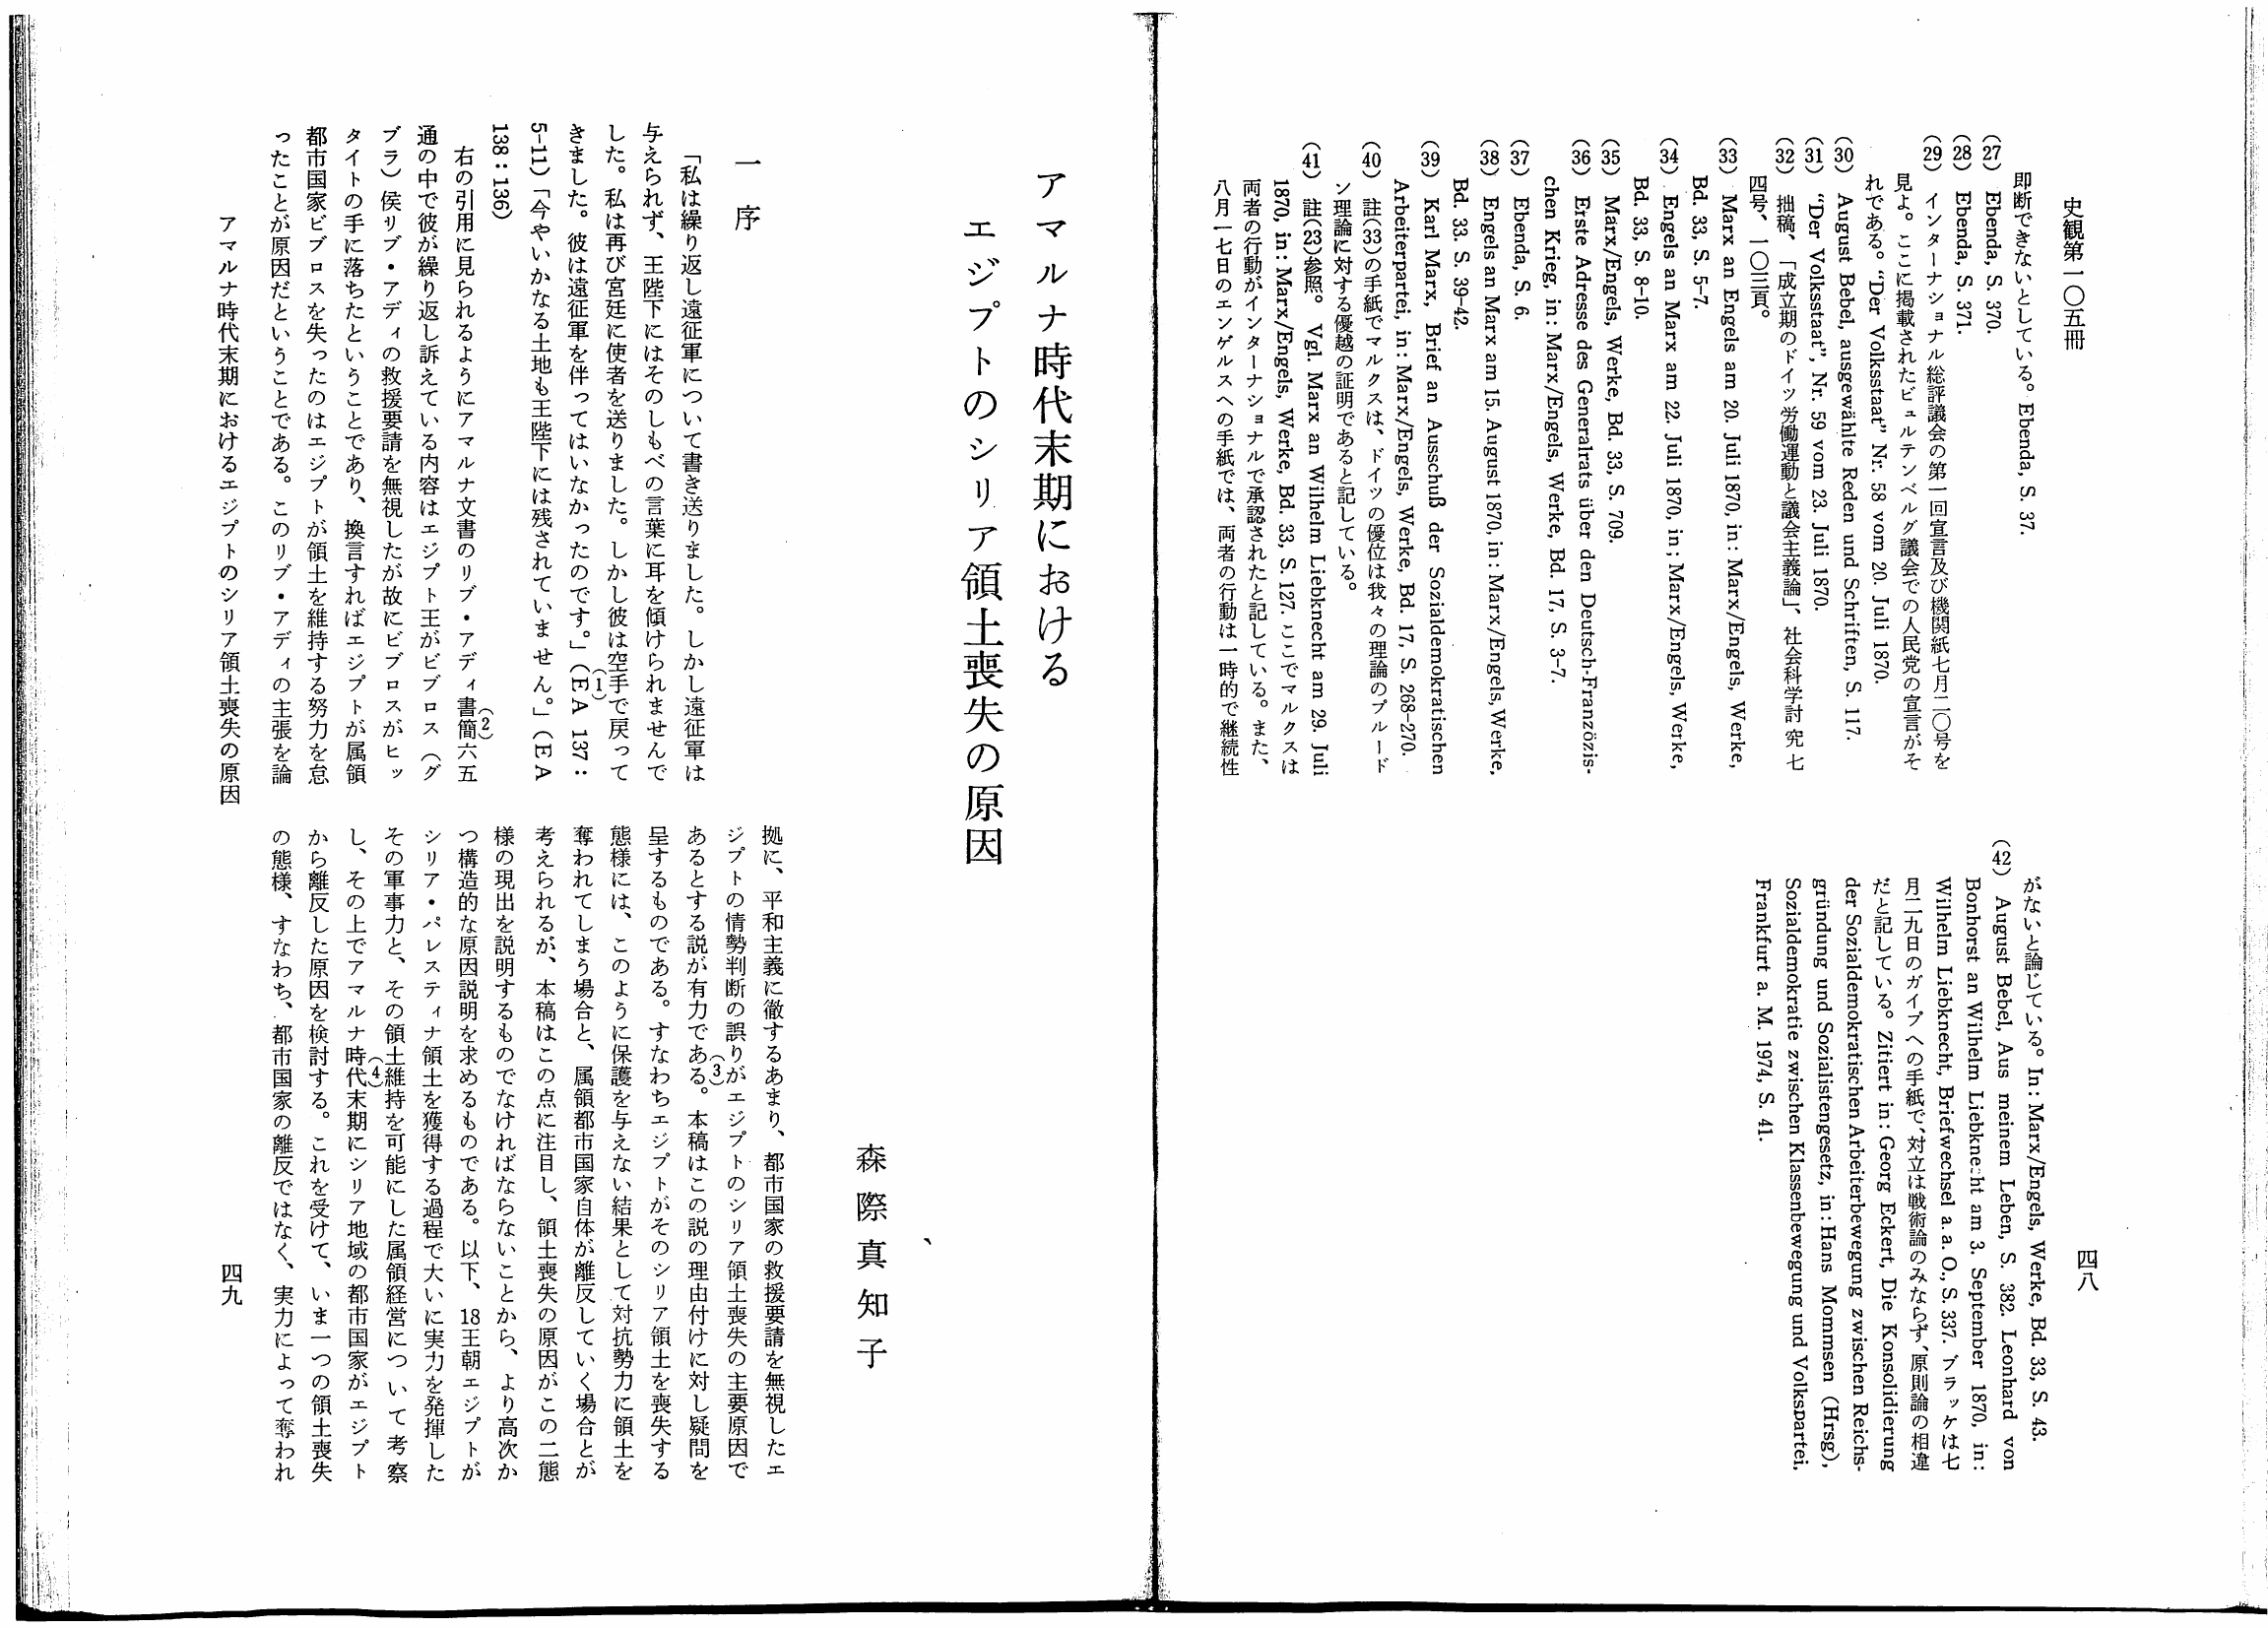

In [ ]:
%cd /content/drive/MyDrive/AWCA/Colab_notebooks/OCR/pDonovan/OCR_OUT_TEST/MixLangTest6/MixLangTest6_16/images
Image.open(sorted(os.listdir())[0])